In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Thêm đường dẫn đến thư mục src để import các module
sys.path.append(os.path.abspath(os.path.join('..')))

from src import data_processing as dp
from src import visualization as viz

# Cấu hình để hiển thị biểu đồ trong notebook
%matplotlib inline

# Tải dữ liệu
filepath = '../data/raw/aug_train.csv'
data = dp.load_data(filepath)

---

# 1. Tổng Quan Dữ Liệu

### 1.1. Thông tin cơ bản

In [2]:
basic_info = dp.get_basic_info(data)
print(f"Số dòng: {basic_info['shape'][0]}")
print(f"Số cột: {basic_info['shape'][1]}")
print(f"Kích thước tổng thể: {basic_info['memory_usage'] / 1e6:.2f} MB")

Số dòng: 19158
Số cột: 14
Kích thước tổng thể: 9.66 MB


**Mỗi dòng trong tập dữ liệu này đại diện cho một ứng viên đã đăng ký tham gia chương trình đào tạo của công ty.**
Dòng dữ liệu mô tả đầy đủ hồ sơ của từng ứng viên, bao gồm thông tin nhân khẩu học, trình độ học vấn, kinh nghiệm làm việc, tình trạng công việc hiện tại, số giờ đào tạo và một biến mục tiêu cho biết họ có đang tìm kiếm cơ hội việc làm mới hay có khả năng gắn bó làm việc cho công ty sau khi hoàn thành khóa đào tạo.


In [3]:
# Hiển thị 5 dòng đầu tiên
print("5 dòng đầu tiên:")
print(data[:5])

# Hiển thị 5 dòng cuối cùng
print("\n5 dòng cuối cùng:")
print(data[-5:])

5 dòng đầu tiên:
[( 8949, 'city_103', 0.92 , 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '1', 36, 1.)
 (29725, 'city_40', 0.776, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'STEM', '15', '50-99', 'Pvt Ltd', '>4', 47, 0.)
 (11561, 'city_21', 0.624, '', 'No relevent experience', 'Full time course', 'Graduate', 'STEM', '5', '', '', 'never', 83, 0.)
 (33241, 'city_115', 0.789, '', 'No relevent experience', '', 'Graduate', 'Business Degree', '<1', '', 'Pvt Ltd', 'never', 52, 1.)
 (  666, 'city_162', 0.767, 'Male', 'Has relevent experience', 'no_enrollment', 'Masters', 'STEM', '>20', '50-99', 'Funded Startup', '4',  8, 0.)]

5 dòng cuối cùng:
[( 7386, 'city_173', 0.878, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'Humanities', '14', '', '', '1',  42, 1.)
 (31398, 'city_103', 0.92 , 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '14', '', '', '4',  52, 1.)
 (24576, 'city_103', 0.92 , 'Mal

### 1.2. Tính toàn vẹn của dữ liệu

In [4]:
duplicate_info = dp.check_duplicates(data)
print(f"Số dòng trùng lặp (không tính enrollee_id): {duplicate_info['duplicated_rows']}")
print(f"Tỷ lệ trùng lặp: {duplicate_info['duplicated_percentage']:.2f}%")

Số dòng trùng lặp (không tính enrollee_id): 49
Tỷ lệ trùng lặp: 0.26%


In [5]:
# Hiển thị các dòng trùng lặp nếu có
if duplicate_info['duplicated_rows'] > 0:
    print("\nCác dòng được xác định là trùng lặp:")
    for duplicate in duplicate_info['representative_duplicates']:
        print(duplicate['row'])
        print(f"Count: {duplicate['count']}")
        print()
else:
    print("\nKhông tìm thấy dòng nào trùng lặp.")


Các dòng được xác định là trùng lặp:
(9645, 'city_16', 0.91, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '15', '', '', '>4', 47, 0.)
Count: 2

(22319, 'city_21', 0.624, 'Male', 'No relevent experience', 'no_enrollment', 'Graduate', 'STEM', '<1', '', '', '1', 14, 1.)
Count: 2

(20376, 'city_160', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '', '', '>4', 25, 1.)
Count: 2

(5911, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '100-500', 'Pvt Ltd', '>4', 151, 0.)
Count: 2

(440, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Masters', 'STEM', '>20', '10000+', 'Pvt Ltd', '>4', 42, 0.)
Count: 2

(14361, 'city_103', 0.92, 'Male', 'No relevent experience', 'no_enrollment', 'High School', '', '4', '', '', 'never', 21, 0.)
Count: 2

(31595, 'city_103', 0.92, 'Male', 'Has relevent experience', 'no_enrollment', 'Graduate', 'STEM', '>20', '1000-4999', 'Pvt 

**Xử lý dữ liệu trùng lặp:**

Các dòng trùng lặp **nên được loại bỏ**.

Toàn bộ 49 bản ghi trùng đều xuất hiện **dưới dạng cặp giống hệt nhau trên tất cả các thuộc tính trừ `enrollee_id`**. Điều này cho thấy những bản ghi này thực chất mô tả **cùng một ứng viên** được ghi nhận nhiều lần, không mang thêm thông tin mới.

Tỷ lệ trùng lặp tuy nhỏ (**0.26%**) nhưng việc loại bỏ vẫn cần thiết để đảm bảo dữ liệu **sạch**, tránh tác động tiêu cực đến mô hình dự báo.

In [6]:
# Có bao nhiêu dòng hoàn toàn đủ/trống thông tin
row_completeness = dp.count_row_completeness(data)
print(f"Số dòng đủ hết thông tin: {row_completeness['complete_rows']}")
print(f"Số dòng thiếu hết thông tin: {row_completeness['empty_rows']}")

Số dòng đủ hết thông tin: 8955
Số dòng thiếu hết thông tin: 0


### 1.3. Thông tin cột và kiểu dữ liệu

**Ý nghĩa của từng cột:**

- **enrollee_id**: ID duy nhất cho ứng viên.
- **city**: Mã thành phố.
- **city_development_index**: Chỉ số phát triển của thành phố (đã được scale).
- **gender**: Giới tính của ứng viên.
- **relevent_experience**: Kinh nghiệm liên quan của ứng viên.
- **enrolled_university**: Loại khóa học đại học đã đăng ký (nếu có).
- **education_level**: Trình độ học vấn của ứng viên.
- **major_discipline**: Chuyên ngành học chính của ứng viên.
- **experience**: Tổng số năm kinh nghiệm.
- **company_size**: Số lượng nhân viên trong công ty của nhà tuyển dụng hiện tại.
- **company_type**: Loại hình của nhà tuyển dụng hiện tại.
- **last_new_job**: Chênh lệch số năm giữa công việc trước đó và công việc hiện tại.
- **training_hours**: Số giờ đào tạo đã hoàn thành.
- **target**: Biến mục tiêu.
  - `0`: Không tìm kiếm sự thay đổi công việc.
  - `1`: Đang tìm kiếm sự thay đổi công việc.

**Các cột có liên quan và các cột cần loại bỏ:**

- **Cột cần loại bỏ:** `enrollee_id` là một mã định danh duy nhất và không có giá trị dự đoán. Nó nên được loại bỏ khỏi quá trình huấn luyện mô hình.
- **Các cột liên quan:** Tất cả các cột khác đều có khả năng chứa thông tin hữu ích để dự đoán biến mục tiêu `target`.

In [7]:
print("Kiểu dữ liệu của các cột:")
for name, dtype in basic_info['dtypes'].items():
    print(f"- {name}: {dtype}")

Kiểu dữ liệu của các cột:
- enrollee_id: int64
- city: <U8
- city_development_index: float64
- gender: <U6
- relevent_experience: <U23
- enrolled_university: <U16
- education_level: <U14
- major_discipline: <U15
- experience: <U3
- company_size: <U9
- company_type: <U19
- last_new_job: <U5
- training_hours: int64
- target: float64


**Ghi chú kiểu dữ liệu `<U...`:**

Khi đọc dữ liệu từ file CSV bằng **NumPy** (ví dụ dùng `np.loadtxt` hoặc `np.genfromtxt`), các cột chứa dữ liệu dạng chữ sẽ được NumPy chuyển thành kiểu **chuỗi Unicode** với định dạng **`<U...`**. Ký hiệu này thể hiện kiểu *Unicode string* có độ dài cố định, trong đó số phía sau (ví dụ `<U8`, `<U23`, ...) là **độ dài tối đa của chuỗi trong cột**. Khi NumPy gặp cột chứa ký tự, nó không có kiểu linh hoạt như `object` của pandas, do đó nó buộc phải chọn một kiểu chuỗi Unicode có độ dài đủ lớn để chứa giá trị dài nhất trong cột. 

---

# 2. Phân Tích Giá Trị Thiếu

### 2.1. Đánh giá tổng quan 

In [8]:
missing_summary = dp.get_missing_summary(data)
print("Tóm tắt giá trị thiếu theo từng cột:")
for col, summary in missing_summary.items():
    if summary['missing_count'] > 0:
        print(f"- Cột '{col}': {summary['missing_count']} giá trị thiếu ({summary['missing_percentage']:.2f}%)")

Tóm tắt giá trị thiếu theo từng cột:
- Cột 'company_type': 6140 giá trị thiếu (32.05%)
- Cột 'company_size': 5938 giá trị thiếu (30.99%)
- Cột 'gender': 4508 giá trị thiếu (23.53%)
- Cột 'major_discipline': 2813 giá trị thiếu (14.68%)
- Cột 'education_level': 460 giá trị thiếu (2.40%)
- Cột 'last_new_job': 423 giá trị thiếu (2.21%)
- Cột 'enrolled_university': 386 giá trị thiếu (2.01%)
- Cột 'experience': 65 giá trị thiếu (0.34%)


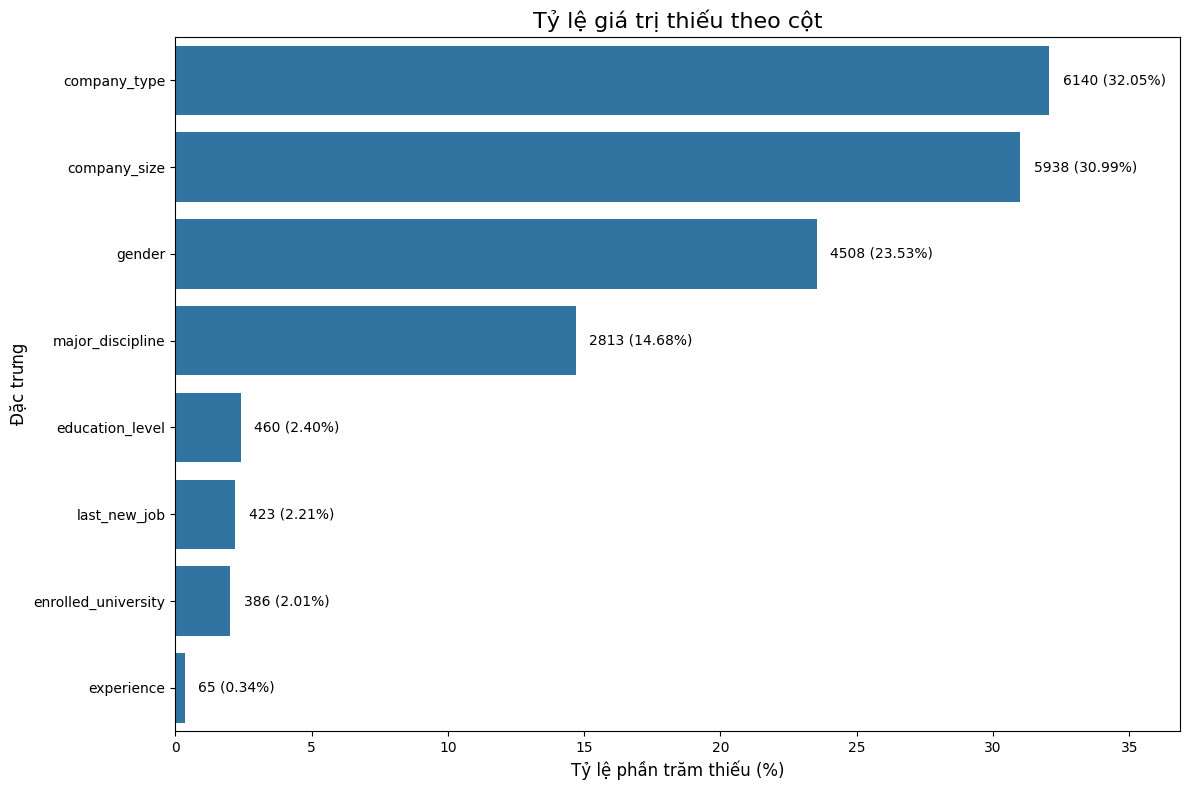

In [9]:
viz.plot_missing_summary(missing_summary)

**Nhận xét:**

**Missing values không random mà có pattern:**
- Các biến liên quan đến **công ty hiện tại** có tỷ lệ thiếu cao nhất và gần như tương đương nhau: `company_type` (32.05%) và `company_size` (30.99%), cho thấy chúng thường thiếu đồng thời
- Biến `gender` (23.53%) và `major_discipline` (14.68%) có tỷ lệ thiếu vừa phải
- Các biến còn lại có tỷ lệ thiếu rất thấp (<3%)

### 2.2. Tỉ lệ target cho trạng thái giá trị thiếu

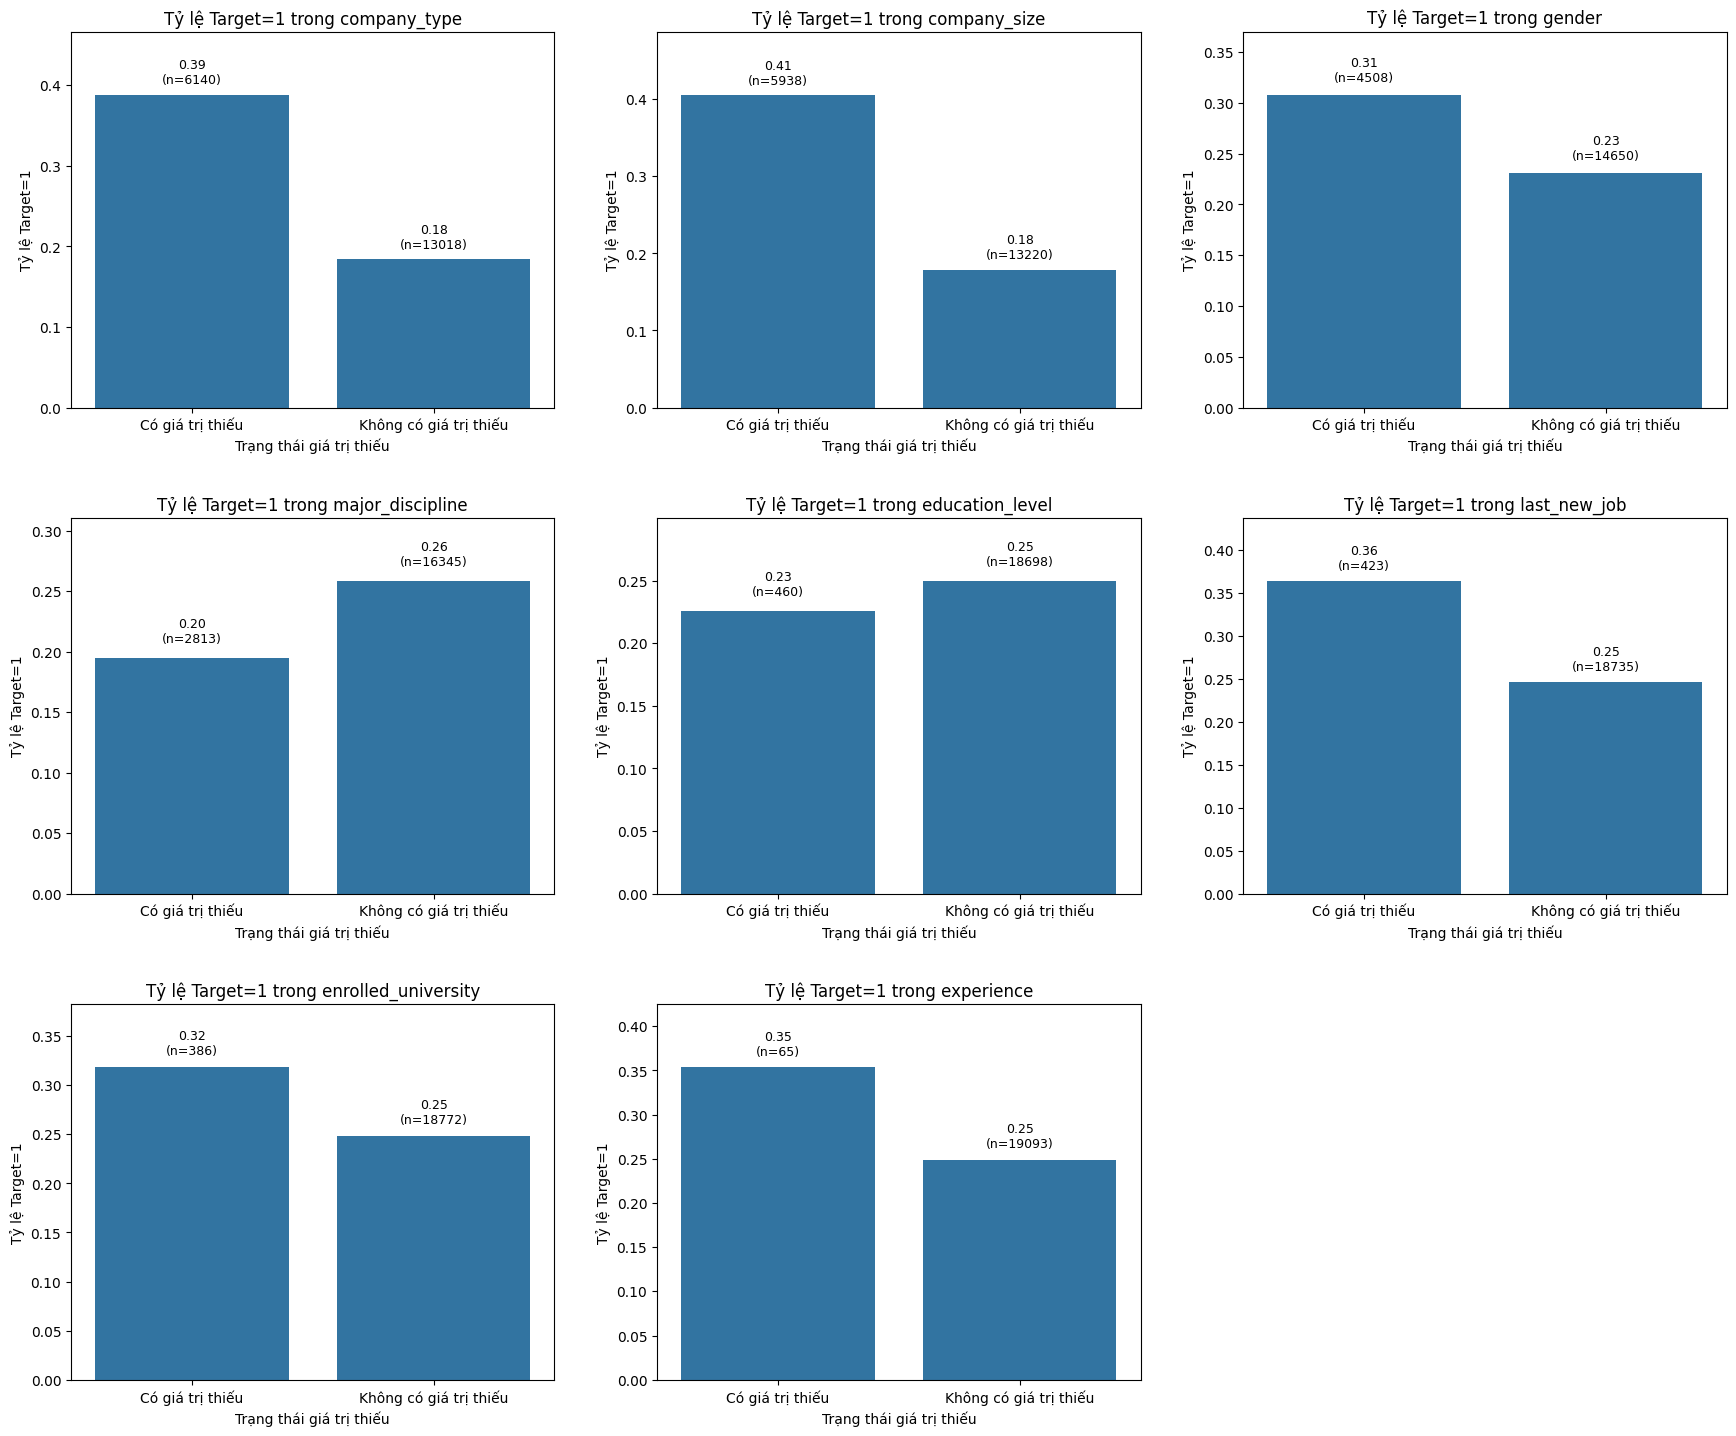

In [10]:
cols_to_compare = [col for col, summary in missing_summary.items() if 0 < summary['missing_percentage'] < 50]
viz.plot_target_rate_by_missing_grid(data, cols_to_compare)

**Nhận xét:**

Phân tích tỷ lệ `target=1` (tìm kiếm việc mới) giữa nhóm có và không có giá trị thiếu cho thấy những khác biệt đáng chú ý:

**Các biến có sự khác biệt lớn:**
- **company_type**: Nhóm có giá trị thiếu có tỷ lệ target=1 cao hơn đáng kể (0.39 so với 0.18), chênh lệch gấp hơn 2 lần. Điều này cho thấy việc thiếu thông tin về loại hình công ty có thể liên quan chặt chẽ đến xu hướng tìm việc mới.
- **company_size**: Tương tự, nhóm thiếu dữ liệu có tỷ lệ target=1 cao hơn (0.41 so với 0.18), thể hiện mối liên hệ mạnh mẽ giữa việc không cung cấp thông tin quy mô công ty và ý định chuyển việc.

**Các biến có sự khác biệt vừa phải:**
- **last_new_job**: Chênh lệch tương đối với tỷ lệ 0.36 so với 0.25 cho thấy những người không tiết lộ thời gian công việc gần nhất có xu hướng tìm việc cao hơn.
- **gender**: Chênh lệch tương đối (0.31 so với 0.23), cho thấy việc thiếu thông tin giới tính cũng có liên quan đến hành vi tìm việc.
- **enrolled_university**: Nhóm thiếu dữ liệu có tỷ lệ 0.32 so với 0.25, phản ánh khả năng những người không cung cấp thông tin học vấn có động cơ tìm việc mạnh hơn.
- **experience**: Tỷ lệ 0.35 so với 0.25 mặc dù số lượng quan sát thiếu rất nhỏ (n=65).

**Các biến có sự khác biệt nhỏ:**
- **education_level** và **major_discipline**: Chênh lệch không đáng kể giữa hai nhóm (0.23 vs 0.25 và 0.20 vs 0.26), cho thấy việc thiếu dữ liệu ở các biến này ít tác động đến biến mục tiêu.

**Kết luận:**
Bản thân việc thiếu dữ liệu, đặc biệt ở các biến liên quan đến thông tin công ty hiện tại (company_type, company_size) là một tín hiệu dự báo mạnh mẽ cho xu hướng tìm kiếm việc làm mới. 

---

# 3. Phân Tích Đơn Biến

### 3.1. Phân tích biến mục tiêu 

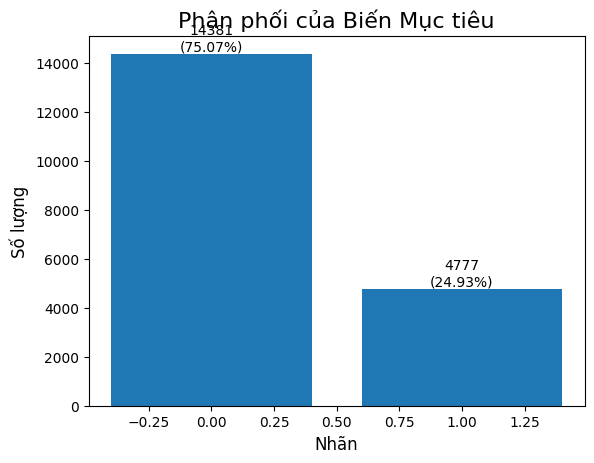

In [11]:
target_dist = dp.get_target_distribution(data)
viz.plot_target_distribution(target_dist['counts'], target_dist['percentages'])

**Nhận xét:**

- Tập dữ liệu bị **mất cân bằng nghiêm trọng** với lớp `target=0.0` chiếm đa số (khoảng 75%) so với lớp `target=1.0` (khoảng 25%). Tỷ lệ này là khoảng 3:1. Điều này cần được xử lý trong giai đoạn mô hình hóa.
- Tập dữ liệu có **nhãn nhị phân**, hiện tại đang được biểu diễn là `0.0` và `1.0`, cần đổi về dạng `int` là `0` và `1`. 

### 3.2. Phân tích các biến numerical

In [12]:
numerical_cols = [name for name, dtype in data.dtype.fields.items() if np.issubdtype(dtype[0], np.number)]
numerical_cols.remove('enrollee_id')
if 'target' in numerical_cols:
    numerical_cols.remove('target')
print(f"Các biến số ({len(numerical_cols)}): {numerical_cols}")

Các biến số (2): ['city_development_index', 'training_hours']


#### a. Phân phối và xu hướng trung tâm

In [13]:
numerical_summary = dp.get_numerical_summary(data, numerical_cols)
for col, summary in numerical_summary.items():
    print(f"Thống kê mô tả cho cột '{col}':")
    for stat, value in summary.items():
        print(f"  {stat:<10} {value:>10.2f}")

Thống kê mô tả cho cột 'city_development_index':
  count        19158.00
  mean             0.83
  std              0.12
  min              0.45
  25%              0.74
  50%              0.90
  75%              0.92
  max              0.95
Thống kê mô tả cho cột 'training_hours':
  count        19158.00
  mean            65.37
  std             60.06
  min              1.00
  25%             23.00
  50%             47.00
  75%             88.00
  max            336.00


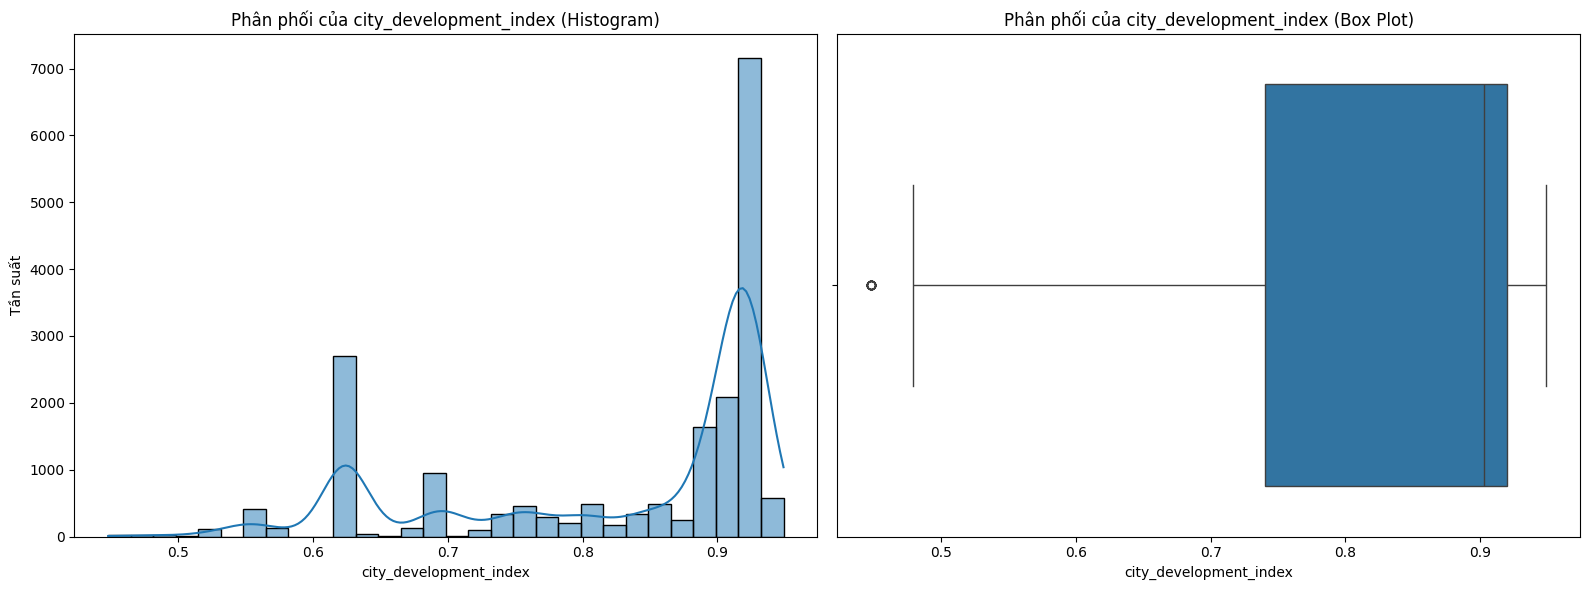

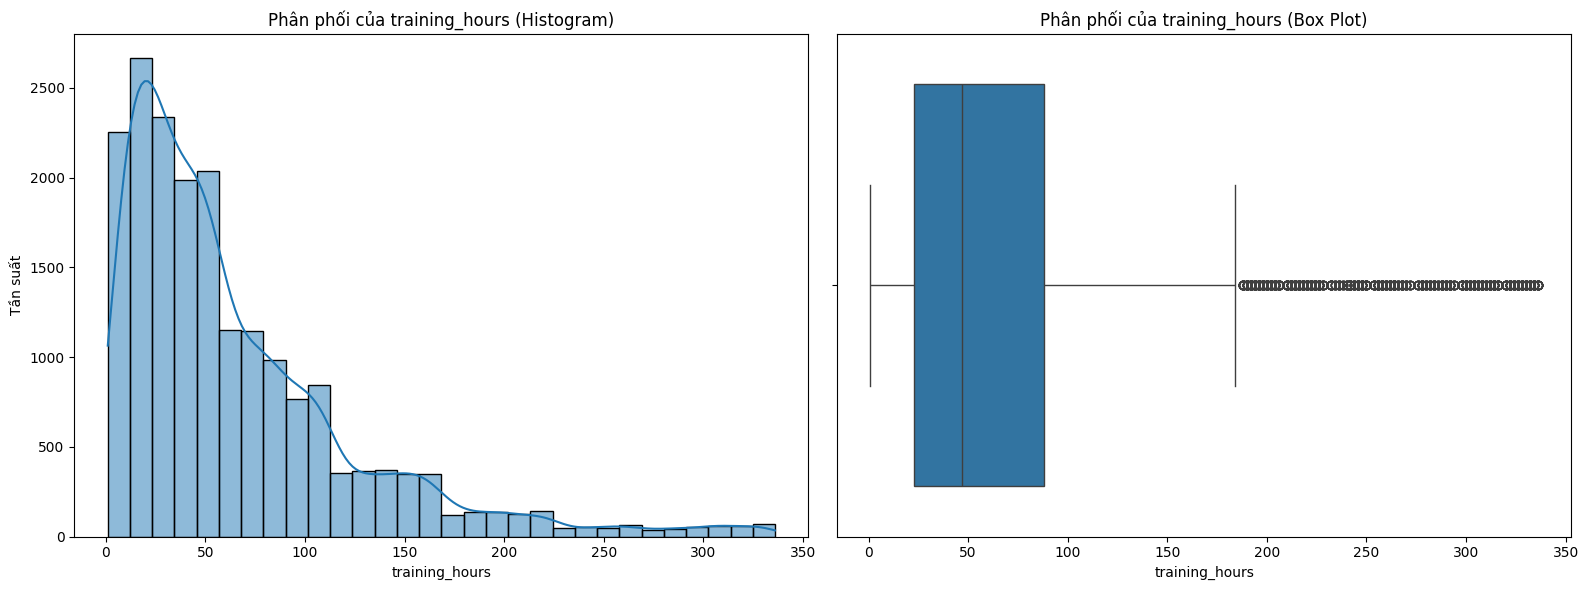

In [14]:
for col in numerical_cols:
    viz.plot_numerical_distribution_and_boxplot(data, col)

**Phân phối:**
- **`city_development_index`**: Phân phối multimodal với hai đỉnh rõ rệt tại ~0.62 và ~0.92. Đa số ứng viên (>70%) đến từ các thành phố có chỉ số phát triển cao (>0.9), phản ánh việc hầu hết các công ty tuyển dụng đều đến từ các đô thị lớn.
- **`training_hours`**: Phân phối lệch phải mạnh, đỉnh tập trung ở 20-40 giờ. Khoảng 70-80% ứng viên hoàn thành dưới 100 giờ đào tạo, cho thấy đa số chỉ tham gia các khóa học ngắn.

**Outliers:**
- **`city_development_index`**: Có một số outliers ở phía giá trị thấp (<0.5), đại diện cho các thành phố kém phát triển. Số lượng ít nên có thể giữ lại hoặc xử lý riêng tùy theo phân tích sâu hơn.
- **`training_hours`**: Có rất nhiều outliers ở phía trên (>~180 giờ), thể hiện nhóm ứng viên có cam kết cao với việc học.

#### b. Tương quan giữa biến numerical và target

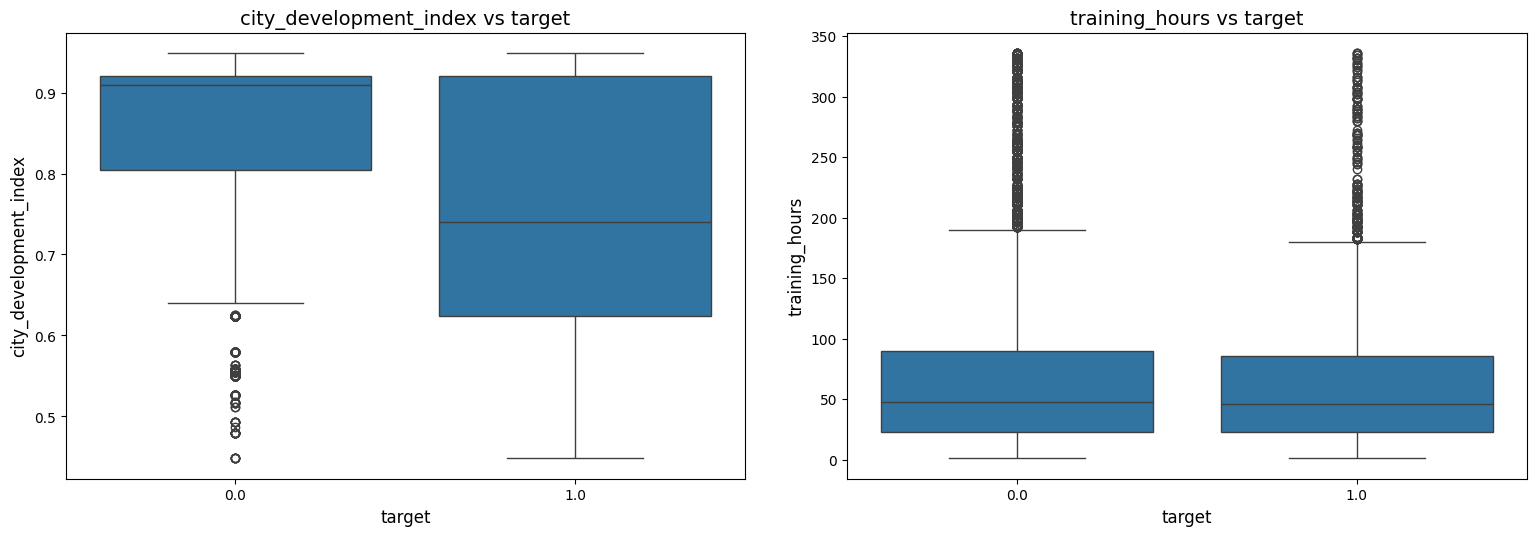

In [15]:
viz.plot_numerical_vs_target_grid(data, numerical_cols)

- **`city_development_index`**

  * Nhóm **target = 1** có **độ phân tán lớn hơn** (IQR rộng hơn) so với nhóm target = 0.
  * **Median của target = 1 thấp hơn đáng kể** so với target = 0.
  * Nhóm **target = 0** có phân phối tập trung hơn ở mức **cao hơn ~0.9**, trong khi nhóm target = 1 trải rộng từ thấp đến cao.

  **$\Rightarrow$ Ứng viên từ các thành phố kém phát triển hơn có xu hướng tìm việc (target = 1) cao hơn**, nhưng phân phối của họ cũng đa dạng hơn.

- **`training_hours`**

  * Hai nhóm target có **median gần như tương đương**.
  * Phân phối tổng thể giữa hai nhóm **gần như giống nhau**, cả về IQR và vị trí median.
  * Tuy nhiên, quantity outliers (giờ training rất cao) xuất hiện ở **cả hai nhóm** và khá nhiều.

  **$\Rightarrow$ `training_hours` không cho thấy sự khác biệt rõ rệt giữa hai nhóm**, có thể không phải biến phân biệt mạnh khi quan sát đơn biến.


#### c. Đánh giá sự khác biệt về thang đo

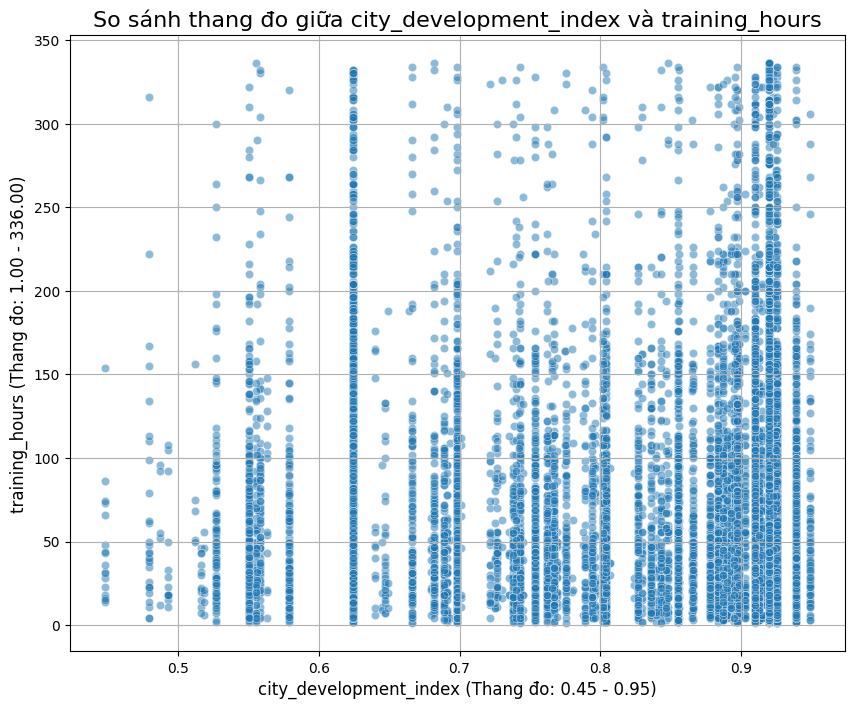

In [16]:
viz.plot_scaling_comparison(data, col1='city_development_index', col2='training_hours')


**Miền giá trị:**
- **`city_development_index`**: Nằm trong khoảng rất hẹp từ 0.45 đến 0.95 (chênh lệch ~0.5)
- **`training_hours`**: Trải rộng từ 1 đến 336 giờ (chênh lệch 336 đơn vị)
- Tỷ lệ chênh lệch giữa hai biến là khoảng **1:672** (336/0.5)

**Vấn đề scaling:**
- Sự khác biệt thang đo rất lớn giữa hai biến sẽ gây ra vấn đề nghiêm trọng cho các thuật toán nhạy cảm với khoảng cách (KNN, SVM, K-Means) hoặc sử dụng gradient descent (Logistic Regression, Neural Networks)
- Nếu không scaling, `training_hours` sẽ **chi phối hoàn toàn** quá trình học của mô hình do giá trị số lớn hơn rất nhiều
- `city_development_index` có thể bị "bỏ qua" mặc dù là yếu tố dự báo quan trọng (như đã thấy ở phân tích trước)

**Quan sát thêm:**
- Dữ liệu tập trung theo các "cột dọc" tại một số giá trị city_development_index cố định (~0.62, ~0.92), phản ánh phân phối multimodal
- Không có mối tương quan tuyến tính rõ ràng giữa hai biến

**Kết luận:** 
Bắt buộc phải áp dụng **chuẩn hóa** cho tất cả các biến số trước khi huấn luyện mô hình để đảm bảo mỗi đặc trưng đóng góp công bằng vào quá trình dự báo.

In [17]:
np.unique(data['city_development_index']).shape

(93,)

In [18]:
np.unique(data['city']).shape

(123,)

#### d. Chất lượng dữ liệu

In [19]:
print("Kiểm tra các giá trị không thể có:")
print(f"Số giờ đào tạo <= 0: {np.sum(data['training_hours'] <= 0)}")
print(f"Chỉ số phát triển thành phố < 0: {np.sum(data['city_development_index'] < 0)}")
print(f"Chỉ số phát triển thành phố > 1: {np.sum(data['city_development_index'] > 1)}")

Kiểm tra các giá trị không thể có:
Số giờ đào tạo <= 0: 0
Chỉ số phát triển thành phố < 0: 0
Chỉ số phát triển thành phố > 1: 0


**Nhận xét:**
Không có giá trị bất khả thi nào được tìm thấy trong các cột số. Dữ liệu có vẻ sạch về mặt này.

### 3.3. Phân tích các biến phân loại

In [20]:
categorical_cols = [name for name, dtype in data.dtype.fields.items() if not np.issubdtype(dtype[0], np.number)]
print(f"Các biến phân loại ({len(categorical_cols)}): {categorical_cols}")

Các biến phân loại (10): ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level', 'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']


#### a. Chất lượng dữ liệu

In [21]:
print("Kiểm tra tính nhất quán của các giá trị phân loại:")
for col in categorical_cols:
    unique_vals = np.unique(data[col])
    if col == 'city':
        # Chỉ in số giá trị vì cột city có quá nhiều giá trị
        print(f"- Cột '{col}' ({len(unique_vals)} giá trị khác)")
        continue
    print(f"- Cột '{col}' ({len(unique_vals)} giá trị khác nhau): {unique_vals}")

Kiểm tra tính nhất quán của các giá trị phân loại:
- Cột 'city' (123 giá trị khác)
- Cột 'gender' (4 giá trị khác nhau): ['' 'Female' 'Male' 'Other']
- Cột 'relevent_experience' (2 giá trị khác nhau): ['Has relevent experience' 'No relevent experience']
- Cột 'enrolled_university' (4 giá trị khác nhau): ['' 'Full time course' 'Part time course' 'no_enrollment']
- Cột 'education_level' (6 giá trị khác nhau): ['' 'Graduate' 'High School' 'Masters' 'Phd' 'Primary School']
- Cột 'major_discipline' (7 giá trị khác nhau): ['' 'Arts' 'Business Degree' 'Humanities' 'No Major' 'Other' 'STEM']
- Cột 'experience' (23 giá trị khác nhau): ['' '1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '3' '4'
 '5' '6' '7' '8' '9' '<1' '>20']
- Cột 'company_size' (9 giá trị khác nhau): ['' '10/49' '100-500' '1000-4999' '10000+' '50-99' '500-999' '5000-9999'
 '<10']
- Cột 'company_type' (7 giá trị khác nhau): ['' 'Early Stage Startup' 'Funded Startup' 'NGO' 'Other' 'Public Sector'
 'Pvt Ltd']
- Cộ

**Nhận xét:**

**Tính nhất quán của các biến phân loại:**
- **Không có lỗi chính tả hoặc biến thể:** Các giá trị trong từng cột đều nhất quán, không có trường hợp như 'Male'/'male' hoặc 'Graduate'/'graduate'
- **Giá trị rỗng (`''`)**: Xuất hiện ở 8 trong 10 biến phân loại, đại diện cho missing values đã được phân tích ở phần trước
- **Giá trị 'Other'**: Xuất hiện ở `gender`, `major_discipline`, và `company_type`, là các giá trị hợp lệ để nhóm các trường hợp không thuộc các category chính

**Các biến cần lưu ý:**
- **`experience`**: Có 23 giá trị khác nhau bao gồm cả số (1-20), khoảng ('<1', '>20'), và missing (''). Biến này có thể cần chuyển đổi sang dạng số hoặc ordinal encoding
- **`company_size`**: Có 9 giá trị với các khoảng không đồng nhất ('10/49', '50-99',..., '10000+'). Cần ordinal encoding hoặc nhóm lại
- **`last_new_job`**: Có 7 giá trị bao gồm số (1-4), khoảng ('>4'), và 'never'. Cần xử lý thứ tự tăng dần
- **`city`**: Có tới 123 giá trị khác nhau, chiếm gần 1% tổng số dòng. Cần cân nhắc sử dụng target encoding hoặc frequency encoding thay vì one-hot encoding

**Kết luận:** Chất lượng dữ liệu của các biến phân loại khá tốt, không có lỗi nhập liệu rõ ràng. Tuy nhiên, cần chuyển đổi một số biến ordinal và xử lý high-cardinality cho biến `city`.

#### b. Phân phối giá trị

##### city

Do cột `city` có **123 giá trị khác nhau** (cardinality cao) nên sẽ chỉ hiển thỉ `top_n` thành phố.

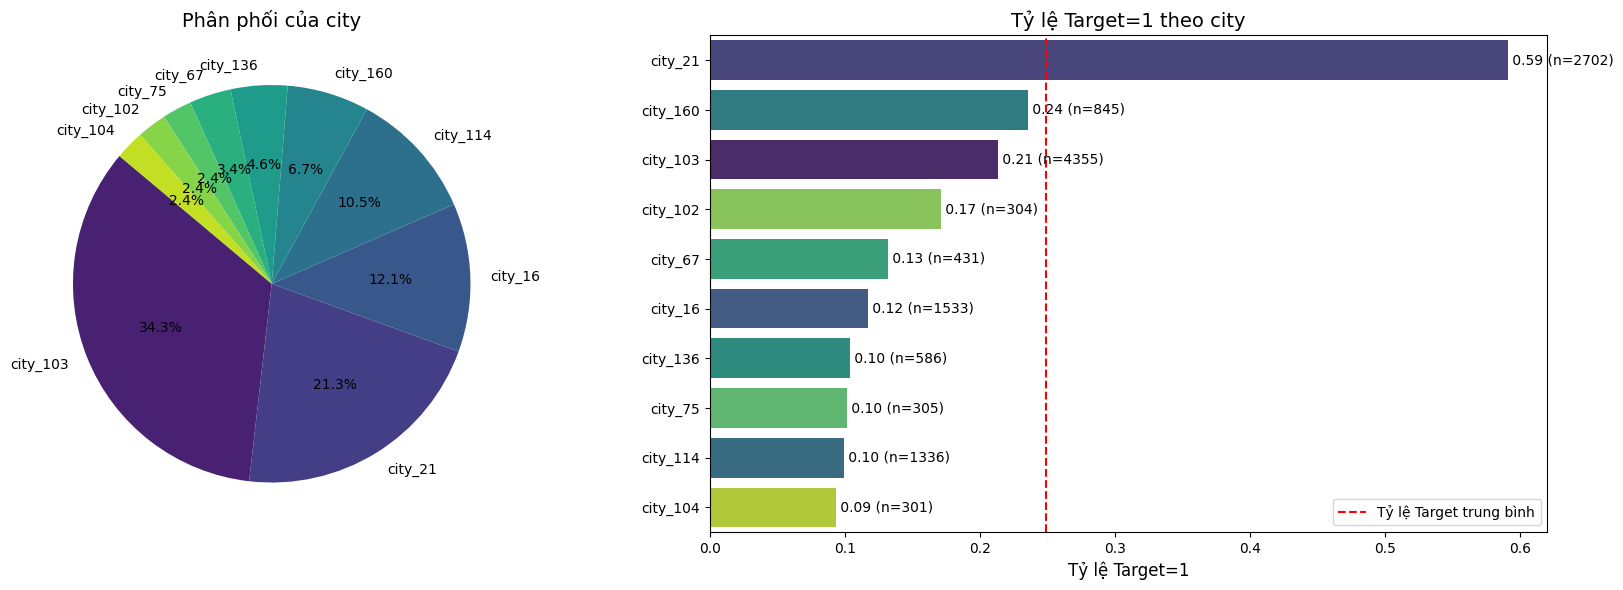

In [22]:
viz.plot_categorical_analysis(data, 'city', top_n=10)

**Nhận xét:**

**Phân phối city:**
- Biến `city` có **123 giá trị duy nhất** (high cardinality), biểu đồ chỉ hiển thị top 10 thành phố có nhiều ứng viên nhất
- **city_103** chiếm nhiều nhất với 4,355 ứng viên (~22.7%), gấp đôi thành phố xếp thứ 2
- Top 4 thành phố  chiếm **~52%** tổng số ứng viên
- Các thành phố còn lại (từ top 5 trở đi) có số lượng chênh lệch ít và giảm dần đều.

**Tỷ lệ target theo city:**
- **city_21** có tỷ lệ target=1 **cao nhất** (0.59), cao gấp hơn 2 lần mức trung bình (~0.25)
- **city_160**: gần mức trung bình
- Các thành phố còn lại đều thấp hơn mức trung bình đáng kể

**Insight:**
- Có sự **khác biệt lớn** về tỷ lệ tìm việc giữa các thành phố (0.09-0.59), cho thấy yếu tố địa lý quan trọng
- **city_21** có tỷ lệ cao bất thường $\rightarrow$ Có thể là thành phố nhỏ với ít cơ hội việc làm hoặc đang phát triển nhanh
- **city_103** (đông nhất) có tỷ lệ thấp $\rightarrow$ Có thể là thành phố lớn, phát triển với nhiều cơ hội việc làm, nhân viên ổn định hơn
- Biến này cần kết hợp với `city_development_index` để hiểu rõ hơn

**Kết luận:** `city` có **high cardinality** (123 giá trị) nên không nên dùng one-hot encoding. Khuyến nghị sử dụng **target encoding** hoặc **frequency encoding**, hoặc group các thành phố nhỏ thành "Other" để giảm số chiều.

##### gender

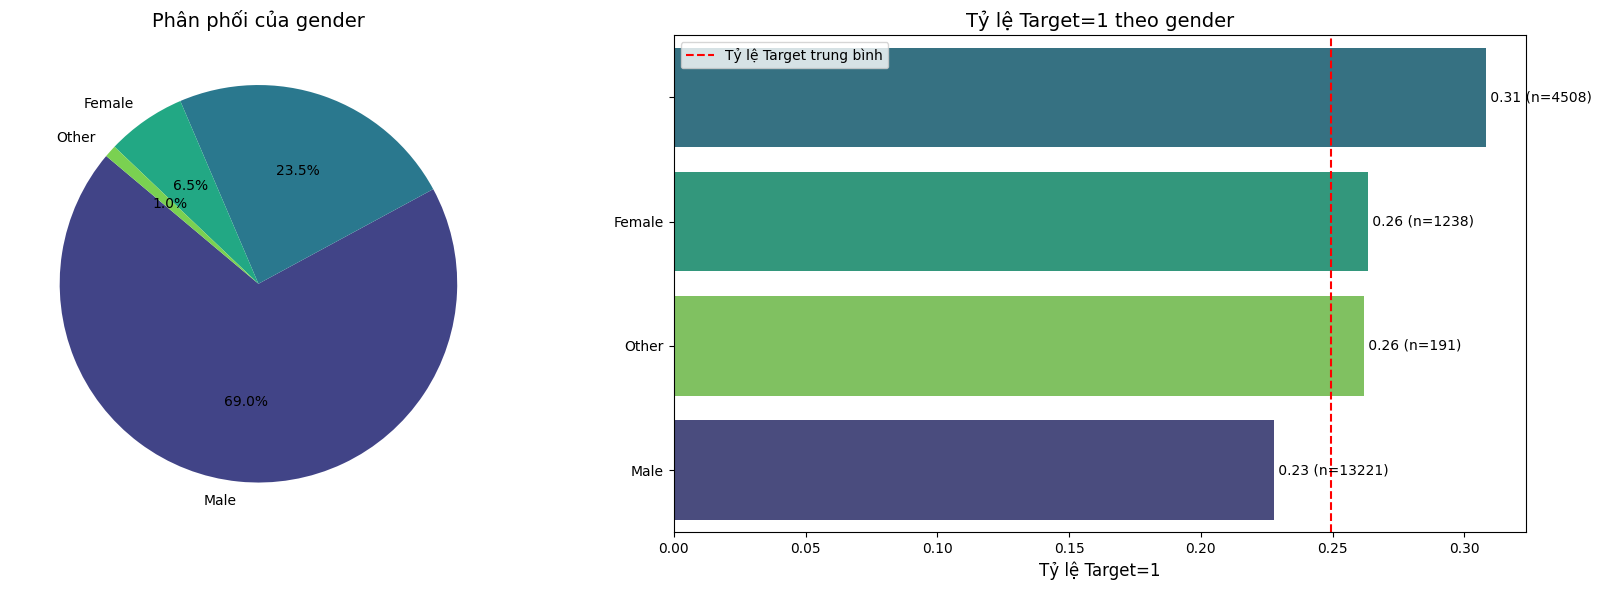

In [23]:
viz.plot_categorical_analysis(data, 'gender')

**Nhận xét:**

**Phân phối gender:**
- **Male** chiếm tuyệt đại đa số với 13,221 ứng viên (~69%), trong khi Female chỉ có 1,238 (~6.5%) và Other 191 (~1%)
- Có 4,508 giá trị missing (~23.5%), đã được phân tích ở phần trước
- Dữ liệu có sự **mất cân bằng nghiêm trọng** về giới tính, phản ánh thực tế ngành Data Science đang bị nam giới thống trị

**Tỷ lệ target theo gender:**
- **Missing values** có tỷ lệ target=1 cao nhất (0.31), cao hơn mức trung bình
- **Male** có tỷ lệ dưới mức trung bình, trong khi **Female và Other** có tỷ lệ tương đương nhau và gần với mức trung bình
- Sự khác biệt giữa các nhóm không quá lớn (0.23-0.31), cho thấy gender có **ảnh hưởng vừa phải** đến quyết định chuyển việc

**Insight:** Việc thiếu thông tin gender lại có tỷ lệ target=1 cao hơn, tương tự pattern đã thấy ở các biến liên quan đến công ty, củng cố giả thuyết về nhóm ứng viên "cố tình không tiết lộ thông tin cá nhân" có xu hướng chuyển việc cao hơn.

##### relevent_experience

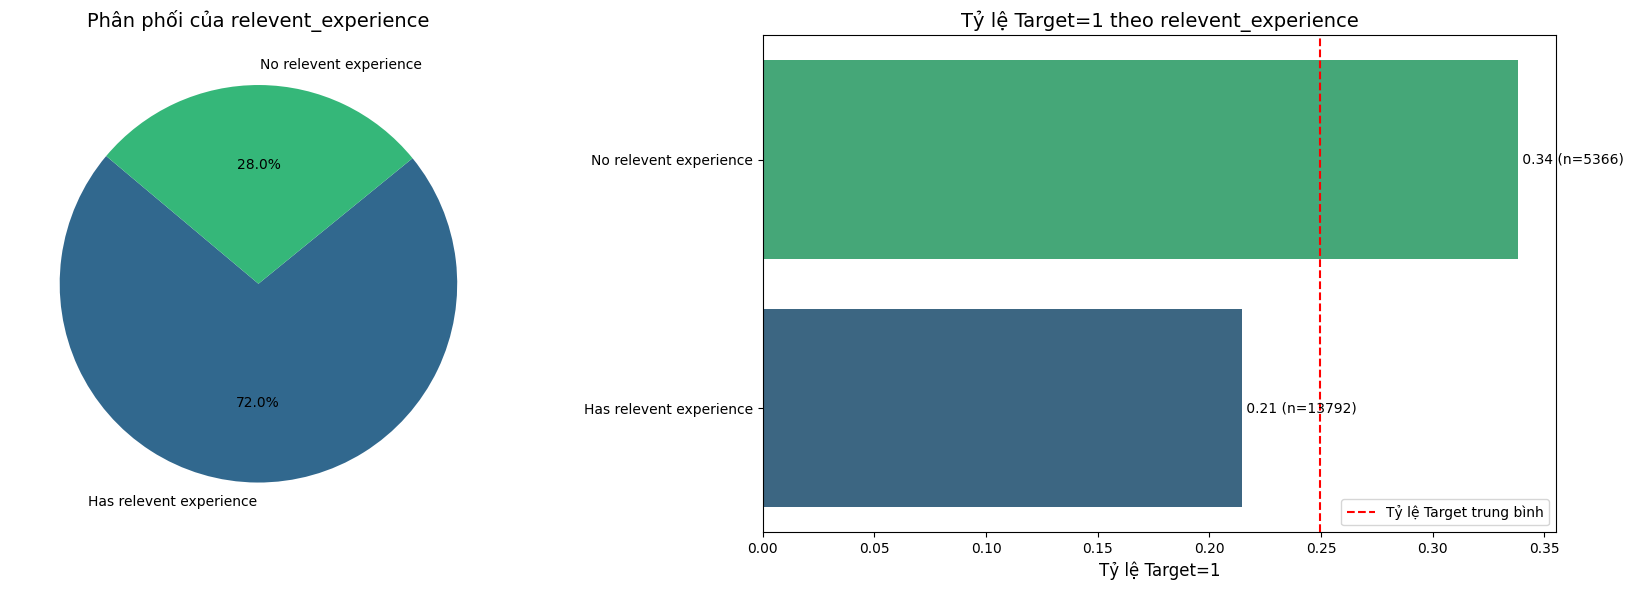

In [24]:
viz.plot_categorical_analysis(data, 'relevent_experience')

**Nhận xét:**

**Phân phối relevant_experience:**
- **Has relevant experience** chiếm đa số tuyệt đối với 13,792 ứng viên (~72%)
- **No relevant experience** chỉ có 5,366 ứng viên (~28%)
- Tỷ lệ 72:28 cho thấy hầu hết ứng viên tham gia khóa đào tạo đã có nền tảng kinh nghiệm liên quan đến Data Science

**Tỷ lệ target theo relevant_experience:**
- **No relevant experience** có tỷ lệ target=1 **cao hơn đáng kể** (0.34 vs 0.21), cao hơn mức trung bình (~0.25)
- Chênh lệch lớn (~62% cao hơn: 0.34/0.21) cho thấy đây là **yếu tố dự báo quan trọng**

**Insight:**
- Người **không có kinh nghiệm** liên quan có xu hướng tìm việc mới cao hơn, có thể vì:
  - Đang muốn chuyển đổi nghề nghiệp hoàn toàn → cần công việc mới để áp dụng kiến thức
  - Chưa có công việc ổn định trong lĩnh vực → đang tích cực tìm kiếm cơ hội
- Người **có kinh nghiệm** có thể chỉ muốn nâng cấp kỹ năng để phát triển ở vị trí hiện tại

**Kết luận:** `relevant_experience` là biến quan trọng, nhóm "No relevant experience" là target audience có khả năng rời công ty cao hơn sau đào tạo.

##### enrolled_university

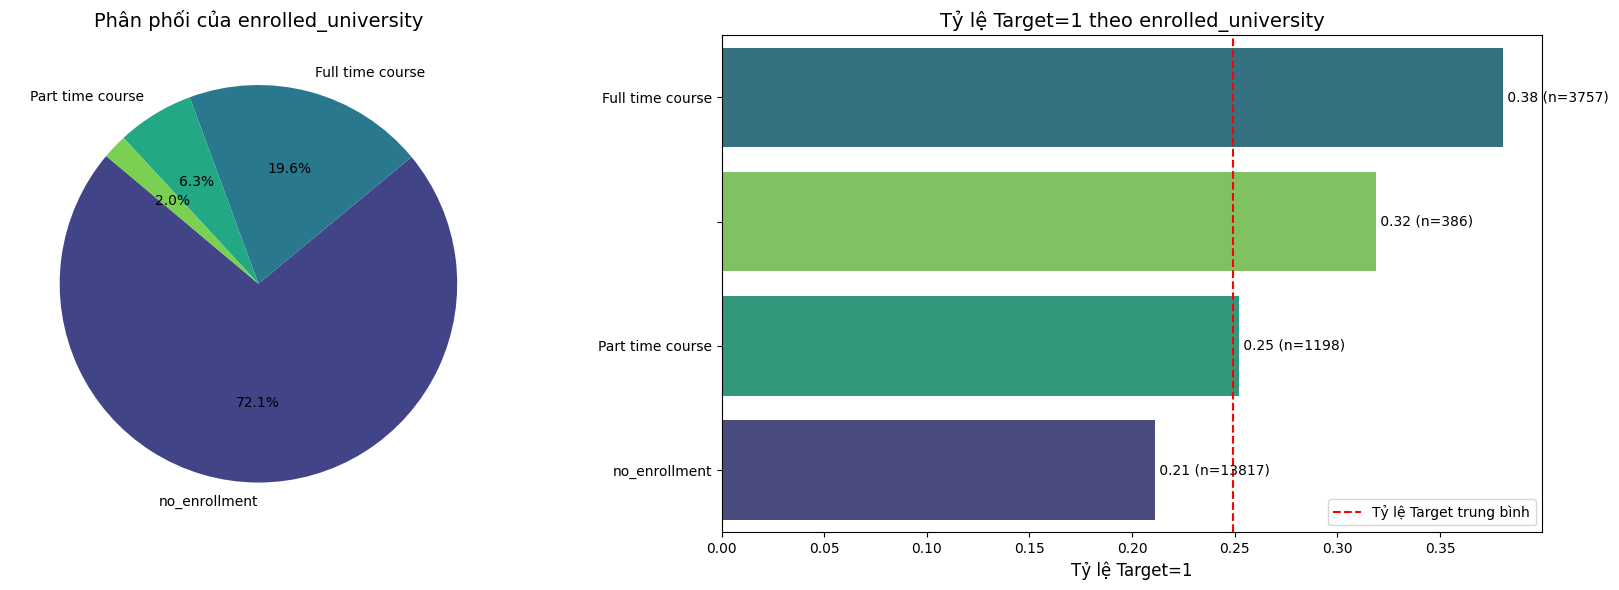

In [25]:
viz.plot_categorical_analysis(data, 'enrolled_university')

**Nhận xét:**

**Phân phối enrolled_university:**
- **no_enrollment** chiếm đa số với 13,817 ứng viên (~72%), cho thấy hầu hết ứng viên không đang theo học đại học.
- Phân phối bị **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía `no_enrollment` cho thấy phần lớn là người không học đại học.

**Tỷ lệ target theo enrolled_university:**
- **Full time course** có tỷ lệ target=1 **cao nhất** (0.38), cao hơn đáng kể so với mức trung bình (~0.25)
- **Missing values** có tỷ lệ 0.32, cũng cao hơn trung bình
- **Part time course** có tỷ lệ bằng mức trung bình (0.25)
- **no_enrollment** có tỷ lệ **thấp nhất** (0.21), dưới mức trung bình

**Insight:**
- Sinh viên **Full time** có xu hướng tìm việc mới cao nhất, có thể vì:
  - Sắp tốt nghiệp và đang tích cực tìm việc đầu tiên
  - Đang học để chuyển đổi nghề nghiệp hoàn toàn
  - Chưa có công việc ổn định nên cần tìm việc sau đào tạo
- Người **không học đại học** (no_enrollment) có xu hướng ở lại công ty cao hơn, có thể đã có công việc ổn định và chỉ muốn nâng cao kỹ năng

**Kết luận:** `enrolled_university` là yếu tố dự báo quan trọng. Nhóm "Full time course" có rủi ro rời công ty cao nhất sau đào tạo.

##### education_level

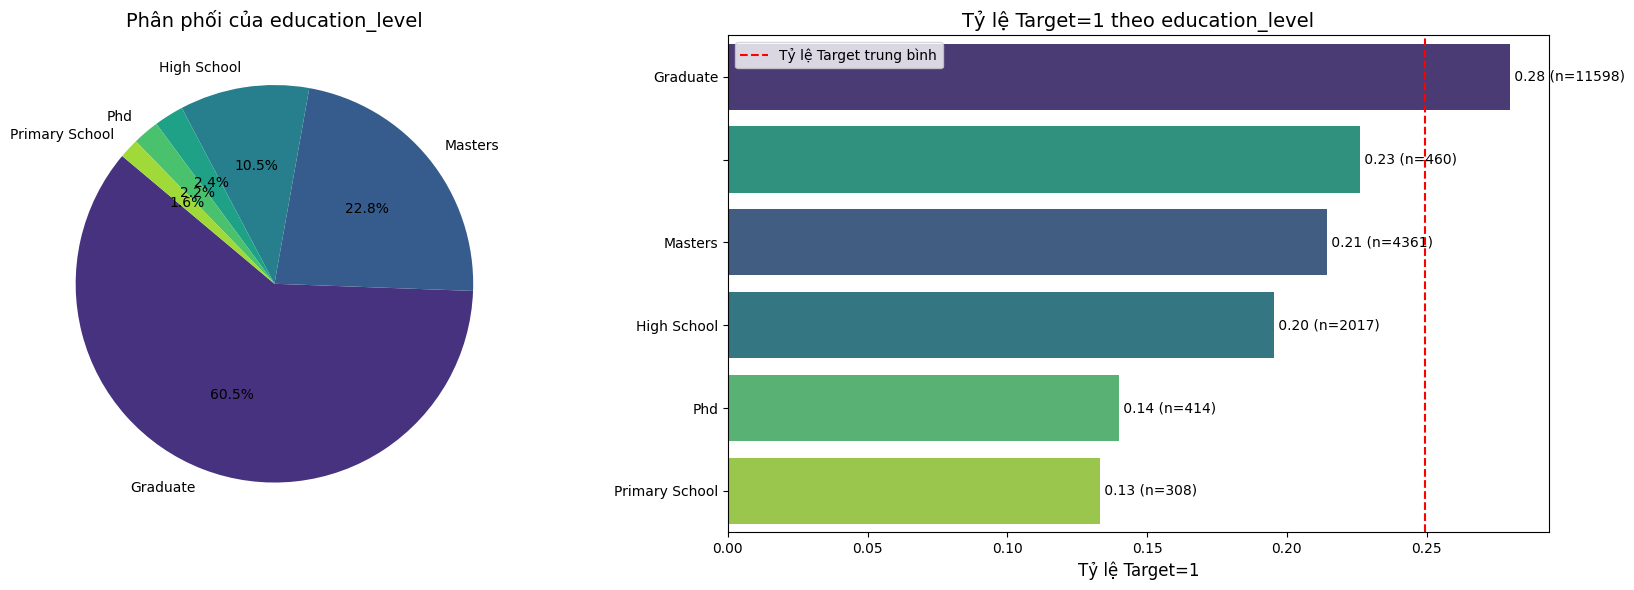

In [26]:
viz.plot_categorical_analysis(data, 'education_level')

**Nhận xét:**

**Phân phối education_level:**
- **Graduate** chiếm đa số áp đảo với 11,598 ứng viên (~60.5%), cho thấy hầu hết ứng viên có bằng đại học. 
- Phân phối bị **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía **Graduate** cho thấy phần lớn là người đã tốt nghiệp đại học.

**Tỷ lệ target theo education_level:**

Có xu hướng **giảm dần** khi trình độ học vấn tăng:
  - **Graduate**: 0.28 (cao hơn mức trung bình ~0.25)
  - **Masters**: 0.21 (gần hoặc dưới mức trung bình)
  - **High School**: 0.20
  - **Phd**: 0.14 (thấp nhất, chỉ bằng một nửa Graduate)
  - **Primary School**: 0.13 (thấp nhất cùng Phd)

**Insight:**
- Người có bằng **Graduate** có xu hướng tìm việc mới cao nhất, có thể vì:
  - Đây là trình độ phổ biến nhất trong ngành Data Science → nhiều cơ hội việc làm
  - Đủ năng lực để di chuyển nhưng chưa quá "cao cấp" như Masters/Phd
- Người có **Phd/Primary School** ít tìm việc hơn, có thể vì:
  - **Phd**: Đã có vị trí ổn định trong nghiên cứu/học thuật, khó tìm việc phù hợp
  - **Primary School**: Giới hạn về trình độ, ít cơ hội chuyển việc

**Kết luận:** `education_level` có mối quan hệ **phi tuyến** với target. Nhóm Graduate có rủi ro rời công ty cao nhất, trong khi Phd thấp nhất.

##### major_discipline

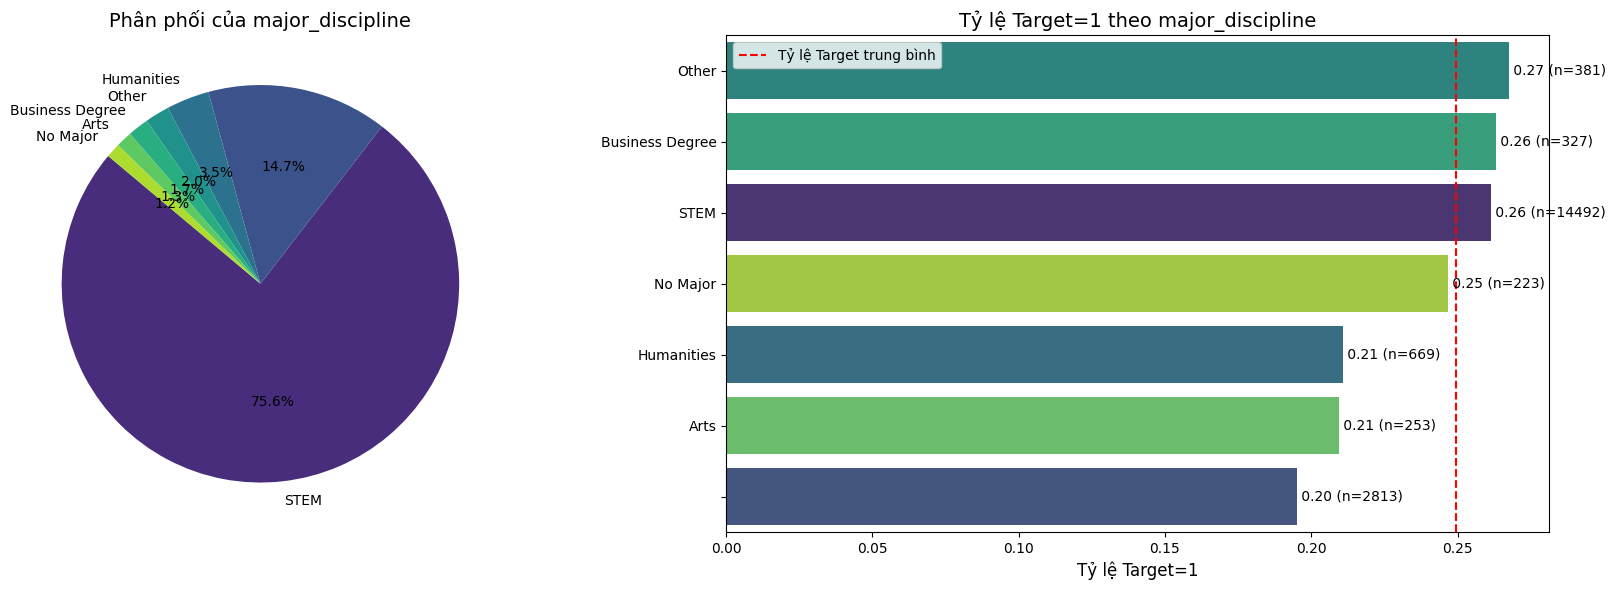

In [27]:
viz.plot_categorical_analysis(data, 'major_discipline')

**Nhận xét:**

**Phân phối major_discipline:**
- **STEM** chiếm đa số áp đảo với 14,492 ứng viên (~75.6%), phản ánh đúng bản chất của lĩnh vực Data Science
- Phân phối bị **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía **STEM** cho thấy phần lớn các ứng viên học về lĩnh vực này.

**Tỷ lệ target theo major_discipline:**
- **Other**, **Business Degree** và **STEM** có tỷ lệ target=1 cao nhất (0.27 và 0.26), cao hơn mức trung bình
- Còn lại đều dưới mức trung bình

**Insight:**
- Người từ chuyên ngành **không phải STEM** (Other, Business) có xu hướng tìm việc cao hơn, có thể vì:
  - Đang chuyển đổi nghề nghiệp hoàn toàn → cần công việc mới để áp dụng
  - Chưa có nền tảng kỹ thuật vững → cần tìm việc entry-level
- Người **STEM** có tỷ lệ trung bình, có thể đã có việc ổn định trong lĩnh vực
- **Humanities/Arts** có tỷ lệ thấp bất ngờ, có thể do số lượng mẫu nhỏ hoặc họ tham gia khóa học vì sở thích hơn là chuyển nghề

**Kết luận:** `major_discipline` có ảnh hưởng vừa phải đến target. Nhóm chuyển đổi từ ngành khác (Other, Business) có xu hướng tìm việc cao hơn STEM.

##### experience

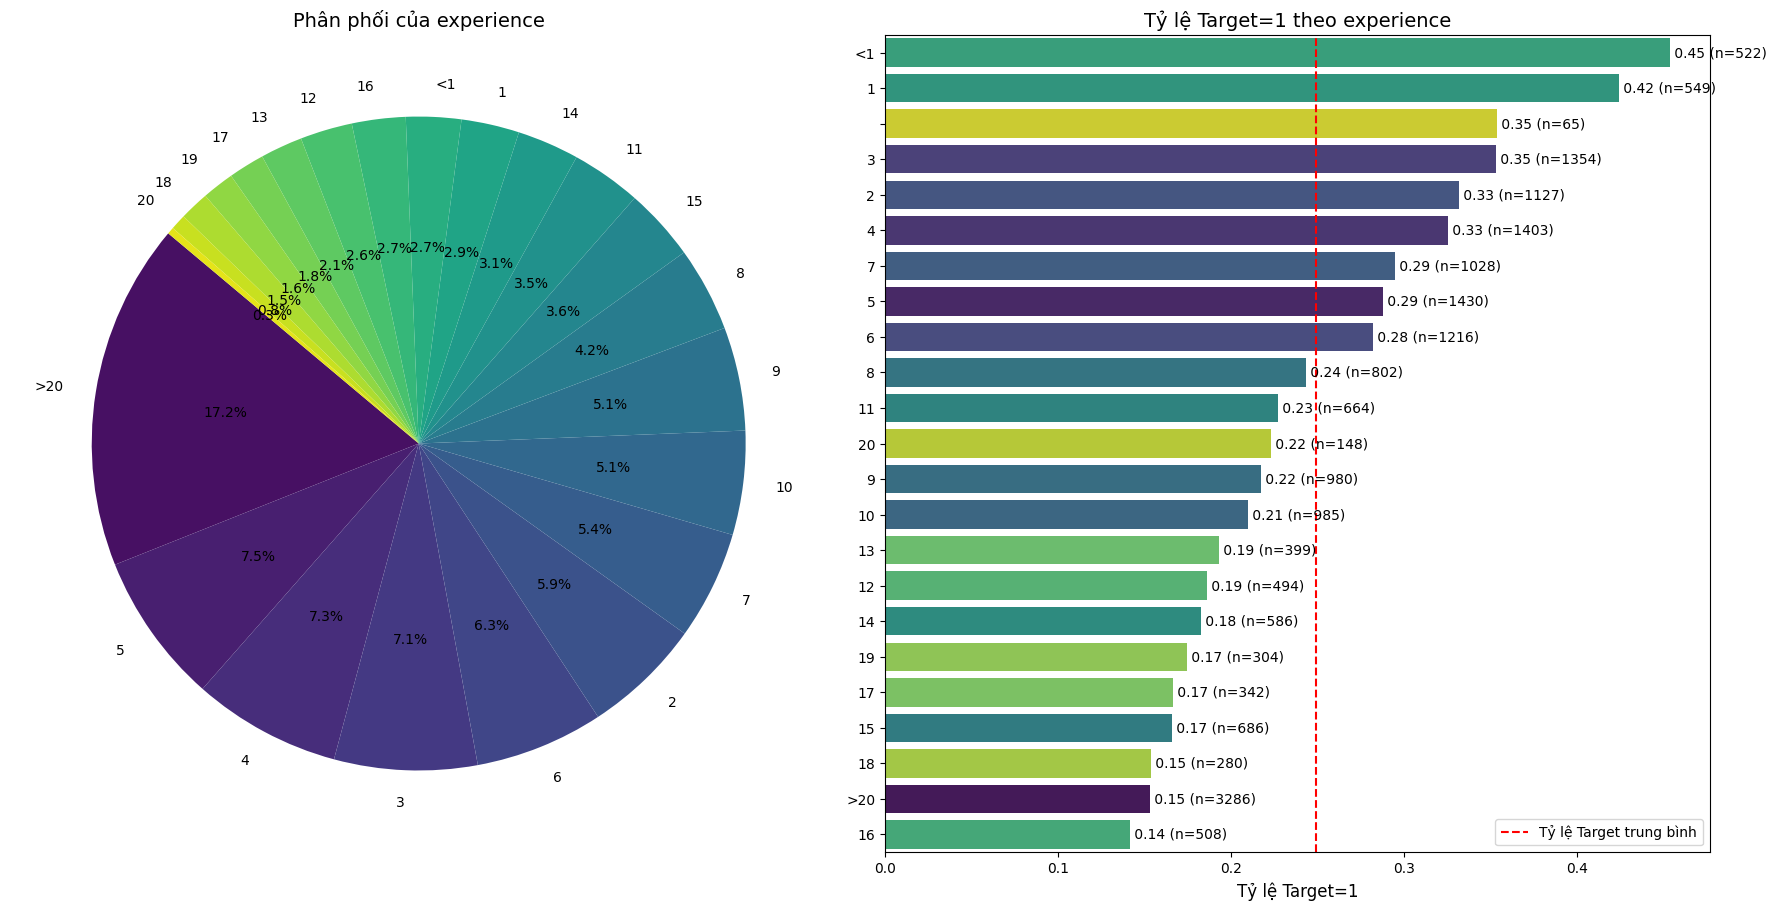

In [28]:
viz.plot_categorical_analysis(data, 'experience')

**Nhận xét:**

**Phân phối experience:**
- **>20 năm** chiếm nhiều nhất với 3,286 ứng viên (~17.1%)
- Phân phối tương đối **đồng đều** qua các khoảng kinh nghiệm từ 1-10 năm (mỗi nhóm ~800-1,400 người)
- **<1 năm**: 522 ứng viên (~2.7%)
- **Missing**: 65 ứng viên (~0.34%) - tỷ lệ thiếu rất thấp
- Có 23 giá trị duy nhất, cho thấy biến này rất chi tiết

**Tỷ lệ target theo experience:**

Có xu hướng **giảm dần** khi kinh nghiệm tăng:
  - **<1 năm và 1 năm**: Tỷ lệ cao nhất (0.45 và 0.42), cao hơn đáng kể so với mức trung bình (~0.25)
  - **2-7 năm**: Tỷ lệ từ 0.29-0.35, cao hơn hoặc gần mức trung bình
  - **8-15 năm**: Tỷ lệ giảm xuống 0.17-0.24, dưới mức trung bình
  - **>15 năm**: Tỷ lệ thấp nhất (0.14-0.17), chỉ bằng ~1/3 nhóm junior

**Insight:**
- **Junior (<3 năm kinh nghiệm)** có xu hướng tìm việc mới cao nhất, có thể vì:
  - Đang trong giai đoạn khám phá nghề nghiệp, sẵn sàng thay đổi
  - Chưa gắn bó lâu dài với công ty hiện tại
  - Muốn tìm cơ hội tốt hơn sau khi nâng cấp kỹ năng
- **Senior (>15 năm)** có xu hướng ở lại thấp nhất, có thể vì:
  - Đã có vị trí và mức lương ổn định
  - Khó tìm việc phù hợp với level cao
  - Chi phí cơ hội khi chuyển việc lớn hơn

**Kết luận:** `experience` là yếu tố dự báo **rất quan trọng** với mối quan hệ **phi tuyến rõ rệt**. Nhóm junior (<3 năm) có rủi ro rời công ty cao gấp ~3 lần nhóm senior (>15 năm).

##### company_size

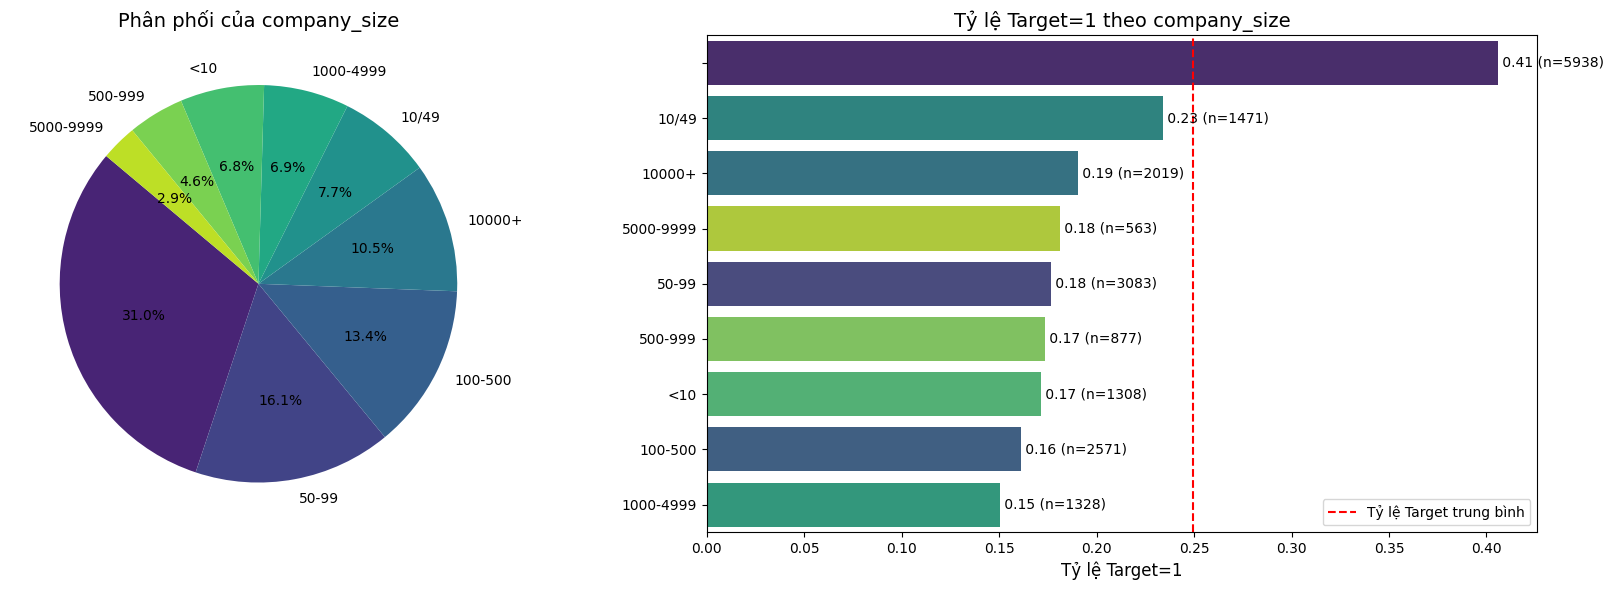

In [29]:
viz.plot_categorical_analysis(data, 'company_size')

**Nhận xét:**

**Phân phối company_size:**
- **Missing** chiếm đa số với 5,938 ứng viên (~31%), phản ánh tỷ lệ thiếu cao đã phân tích trước
- Các quy mô khác phân bố  không cách biệt quá mạnh 

**Tỷ lệ target theo company_size:**
- **Missing** có tỷ lệ target=1 **cao nhất** (0.41), cao hơn rất nhiều so với mức trung bình (~0.25) - củng cố phát hiện ở phân tích missing values
- Còn lại đều dưới mức trung bình

**Insight:**
- `Missing` $\rightarrow$ Tỷ lệ tìm việc cao nhất, có thể là:
  - Sinh viên/người thất nghiệp chưa có công ty
  - Freelancer/tự kinh doanh
  - Cố tình không tiết lộ vì đang muốn rời bỏ công ty hiện tại
- **Công ty nhỏ (10-49 người)** → Tỷ lệ cao thứ hai, có thể vì:
  - Lương thấp, phúc lợi kém hơn công ty lớn
  - Cơ hội phát triển hạn chế
  - Ổn định tài chính kém
- **Công ty lớn/trung bình** → Nhân viên ổn định hơn, ít muốn chuyển việc

**Kết luận:** `company_size` là yếu tố dự báo **rất quan trọng**. Missing value và công ty nhỏ có rủi ro rời bỏ cao gấp ~2-3 lần so với công ty lớn. Cần tạo missing indicator feature.

##### company_type

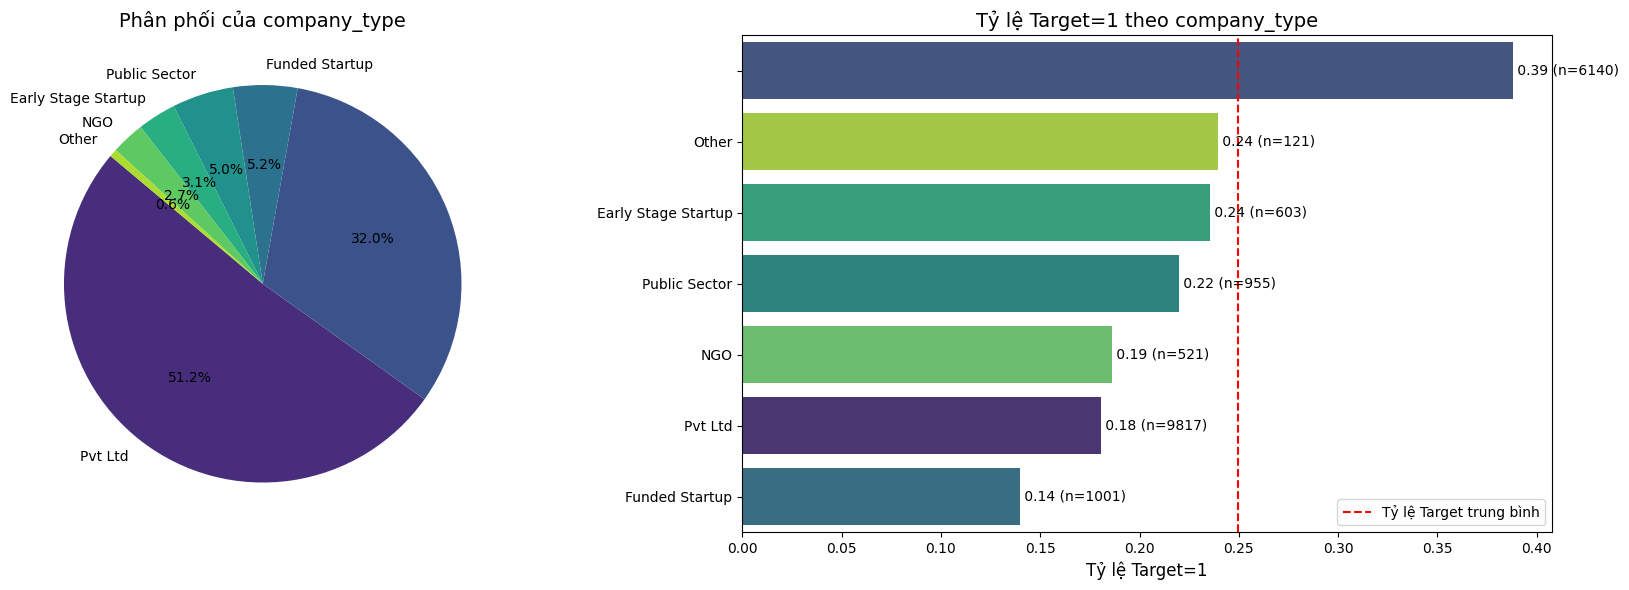

In [30]:
viz.plot_categorical_analysis(data, 'company_type')

**Nhận xét:**

**Phân phối company_type:**
- **Pvt Ltd** (công ty tư nhân) chiếm đa số với 9,817 ứng viên (~51.2%)
- **Missing** có 6,140 ứng viên (~32%), tỷ lệ thiếu cao như đã phân tích
- Còn lại có phân phối khá đều, cho thấy sự **mất cân bằng** nghiêm trọng, nghiêng hẳn về phía `Pvt Ltd` và `Missing`

**Tỷ lệ target theo company_type:**
- **Missing** có tỷ lệ target=1 **cao nhất** (0.39), cao hơn rất nhiều so với mức trung bình (~0.25) - pattern tương tự company_size
- Còn lại đều dưới mức trung bình

**Insight:**
- **Missing** → Tỷ lệ tìm việc cao nhất, củng cố giả thuyết về nhóm không có công ty hoặc cố tình giấu thông tin
- **Early Stage Startup** → Tỷ lệ cao, có thể vì:
  - Công ty không ổn định, rủi ro phá sản
  - Lương thấp, áp lực cao
  - Muốn chuyển sang môi trường tốt hơn
- **Funded Startup** → Tỷ lệ thấp nhất, có thể vì:
  - Đã có funding nên ổn định hơn Early Stage
  - Lương và quyền chọn mua cổ phần hấp dẫn
  - Môi trường năng động, cơ hội thăng tiến
- **Pvt Ltd** (chiếm >50%) → Tỷ lệ thấp, phản ánh sự ổn định của các công ty tư nhân lớn

**Kết luận:** `company_type` là yếu tố dự báo **rất quan trọng**. Missing và Early Stage Startup có rủi ro cao gấp ~3 lần Funded Startup. Cần tạo missing indicator feature và xem xét group các startup lại.

##### last_new_job

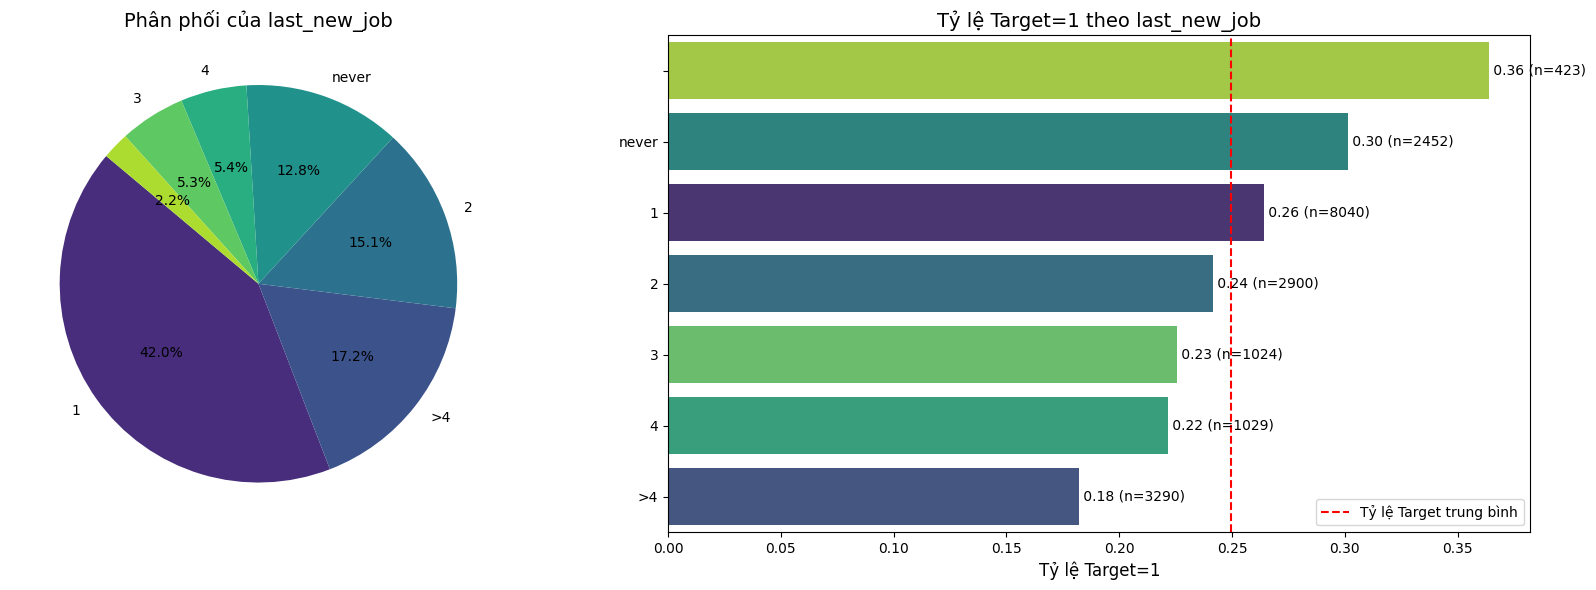

In [31]:
viz.plot_categorical_analysis(data, 'last_new_job')

**Nhận xét:**

**Phân phối last_new_job:**
- **1 năm** chiếm nhiều nhất với 8,040 ứng viên (~42%), cho thấy đa số ứng viên vừa mới chuyển công việc gần đây
- **>4 năm**, **2 năm** và **never** tương đối ngang nhau
- **4 năm**, **3 năm** và **Missing** thuộc nhóm thấp nhất

**Tỷ lệ target theo last_new_job:**
- **Missing** có tỷ lệ target=1 **cao nhất** (0.36), cao hơn đáng kể so với mức trung bình (~0.25)
- **never** và **1 năm**: đều cao hơn mức trung bình
- Còn lại đều dưới mức trung bình

**Insight:**
- **Missing và "never"** → Tỷ lệ tìm việc cao, có thể vì:
  - Missing: Sinh viên mới ra trường chưa có lịch sử việc làm
  - Never: Đang ở công việc đầu tiên, đã sẵn sàng thử thách mới sau đào tạo
- **1-2 năm** (vừa chuyển việc gần đây) → Tỷ lệ trung bình, có thể:
  - Vẫn đang thích nghi với môi trường mới
  - Nhưng cũng sẵn sàng xem xét cơ hội tốt hơn
- **>4 năm** (gắn bó lâu dài) → Tỷ lệ thấp nhất, phản ánh:
  - Đã ổn định và hài lòng với công việc hiện tại
  - Chi phí cơ hội khi chuyển việc cao
  - Có thể đã lên vị trí cao, khó tìm việc tương đương

**Kết luận:** `last_new_job` là yếu tố dự báo **quan trọng** với xu hướng rõ ràng: Người chưa từng chuyển việc hoặc vừa chuyển gần đây có xu hướng tìm việc cao gấp ~2 lần người gắn bó >4 năm. Biến này có tính ordinal cần xử lý đúng thứ tự.

### 3.4. Nhận xét tổng quan về các đặc trưng

Phân tích đơn biến đã cung cấp nhiều insight giá trị về các yếu tố ảnh hưởng đến xu hướng tìm việc của ứng viên:

1.  **Các yếu tố dự báo mạnh nhất:**
    *   **Kinh nghiệm (`experience`, `last_new_job`):** Đây là nhóm yếu tố có ảnh hưởng rõ rệt nhất. Ứng viên có ít kinh nghiệm (đặc biệt là dưới 5 năm) hoặc chưa bao giờ chuyển việc (`never`) có xu hướng tìm việc mới cao hơn đáng kể. Ngược lại, những người có kinh nghiệm lâu năm (>15 năm) hoặc đã gắn bó với công việc hiện tại trên 4 năm rất ổn định và ít có ý định thay đổi.
    *   **Thông tin công ty (`company_size`, `company_type`):** Việc thiếu thông tin về công ty là một tín hiệu dự báo cực kỳ mạnh. Ngoài ra, nhân viên làm việc tại các công ty nhỏ hoặc startup giai đoạn đầu (`Early Stage Startup`) cũng có tỷ lệ tìm việc cao hơn hẳn so với các công ty lớn, công ty tư nhân (`Pvt Ltd`) hoặc startup đã có vốn (`Funded Startup`).
    *   **Tình trạng học vấn (`enrolled_university`):** Sinh viên đang theo học toàn thời gian (`Full time course`) có tỷ lệ tìm việc cao nhất, cho thấy họ đang chuẩn bị cho sự nghiệp sau khi tốt nghiệp hoặc muốn chuyển ngành.

2.  **Các yếu tố dự báo có ảnh hưởng vừa phải:**
    *   **Chỉ số phát triển thành phố (`city_development_index`):** Ứng viên đến từ các thành phố có chỉ số phát triển thấp hơn có xu hướng tìm việc cao hơn. Đây là một yếu tố có giá trị dự báo.
    *   **Kinh nghiệm liên quan (`relevent_experience`):** Những người không có kinh nghiệm liên quan có xu hướng tìm việc cao hơn, có thể vì họ đang muốn chuyển sang một lĩnh vực mới.
    *   **Trình độ học vấn (`education_level`):** Mối quan hệ không hoàn toàn tuyến tính. Nhóm `Graduate` có tỷ lệ tìm việc cao nhất, trong khi nhóm `Masters` và đặc biệt là `Phd` lại có xu hướng ổn định hơn.
    *   **Giới tính (`gender`) và Chuyên ngành (`major_discipline`):** Có sự khác biệt nhưng không quá lớn. Đáng chú ý là việc thiếu thông tin giới tính lại tương quan với tỷ lệ tìm việc cao hơn.

3.  **Các yếu tố có ảnh hưởng yếu hoặc không rõ ràng:**
    *   **Số giờ đào tạo (`training_hours`):** Biến này không cho thấy sự khác biệt rõ rệt giữa hai nhóm `target`. Phân phối của nó gần như giống hệt nhau bất kể ứng viên có tìm việc hay không. Do đó, nó có thể không phải là một yếu tố dự báo mạnh khi đứng một mình.

**Kết luận chung:** Chân dung một ứng viên có khả năng cao đang tìm kiếm công việc mới là người có ít kinh nghiệm, đến từ một thành phố có chỉ số phát triển thấp, đang làm ở một công ty nhỏ/startup hoặc không tiết lộ thông tin công ty, và có thể đang là sinh viên toàn thời gian. Ngược lại, một ứng viên ổn định thường là người có nhiều năm kinh nghiệm, đến từ các thành phố phát triển và làm việc cho một công ty tư nhân lớn hoặc startup đã có vốn.

---

# 4. Phân Tích Đa Biến

### 4.1. Mối quan hệ và tương quan

#### a. Tương quan giữa các biến numerical

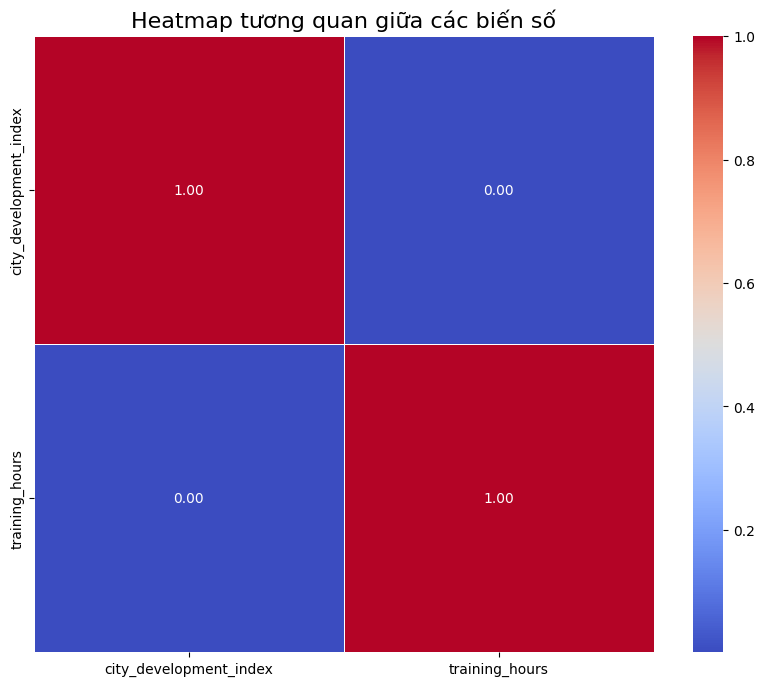

In [32]:
viz.plot_correlation_heatmap(data, numerical_cols)

**Nhận xét:**

Heatmap tương quan cho thấy không có mối tương quan tuyến tính mạnh giữa `city_development_index` và `training_hours`. Điều này cho thấy chúng cung cấp thông tin độc lập cho mô hình.

#### b. Sự dư thừa giữa **city** và **city_development_index**

Một giả thuyết được đặt ra là cột `city` và `city_development_index` có thể chứa thông tin trùng lặp. Cụ thể, mỗi mã thành phố (`city`) có thể chỉ tương ứng với một giá trị chỉ số phát triển (`city_development_index`) duy nhất. Nếu điều này đúng, việc giữ lại cả hai cột trong mô hình có thể dẫn đến sự dư thừa và tăng số chiều không cần thiết.

Phân tích dưới đây sẽ kiểm tra giả thuyết này bằng cách nhóm dữ liệu theo từng thành phố và đếm số lượng `city_development_index` duy nhất cho mỗi thành phố.

In [33]:
# Phân tích mối quan hệ giữa city và city_development_index
city_index_summary = dp.analyze_city_and_index_relationship(data)

# In kết quả
print(f"Tổng số city duy nhất: {city_index_summary['num_unique_cities']}")
print(f"Tổng số index duy nhất: {city_index_summary['num_unique_indices']}")
print(f"Số city ánh xạ tới 1 chỉ số phát triển duy nhất: {city_index_summary['cities_mapping_to_one_index']}")
print(f"Số index được chia sẻ bởi nhiều city: {city_index_summary['indices_shared_by_multiple_cities']}")

Tổng số city duy nhất: 123
Tổng số index duy nhất: 93
Số city ánh xạ tới 1 chỉ số phát triển duy nhất: 123
Số index được chia sẻ bởi nhiều city: 12


**Nhận xét:**

Kết quả phân tích cho thấy **100%** trong số 123 `city` đều ánh xạ tới chính xác **một** giá trị `city_development_index`. Không có thành phố nào được tìm thấy có nhiều hơn một chỉ số phát triển.

Trong khi đó, `city_development_index` đối với `city` là mối quan hệ one-to-many. Một giá trị `city_development_index` có thể ánh xạ tới nhiều giá trị `city` 

**$\Rightarrow$ Giả thuyết là đúng.** Như vậy ta nên loại bỏ một trong hai cột trước khi huấn luyện.

**Tại sao chọn `city_development_index` thay vì `city`?**

**1. `city` là Tên gọi, trong khi `city_development_index` là ggá trị**

Phân tích của chúng ta đã chứng minh mối quan hệ của `city` đối với `city_development_index` là **(many-to-one)**.
- **Nhiều** mã `city` khác nhau cùng trỏ về **một** giá trị `city_development_index` duy nhất.
- Ví dụ: `city_10`, `city_25`, và `city_80` có thể cùng có chỉ số là `0.920`.

Điều này có nghĩa là `city` chỉ là một cái tên hay "nhãn" đại diện cho một đặc tính đã được đo lường bằng `city_development_index`. Giá trị cốt lõi nằm ở con số chỉ số, không phải ở cái tên.

**2. Mô hình Học từ Số liệu, không phải từ Tên gọi**

Mô hình máy học tìm kiếm các quy luật dựa trên số liệu.
- **Lợi ích khi dùng `city_development_index`:** Đây đã là một con số có ý nghĩa. Mô hình có thể học trực tiếp rằng "chỉ số càng thấp thì khả năng tìm việc càng cao".
- **Bất lợi khi dùng `city`:** Đây là một chuỗi ký tự. Mô hình không thể hiểu `city_103` là gì. Để sử dụng nó, ta phải thực hiện các bước mã hóa (encoding) phức tạp để biến nó thành số, trong khi `city_development_index` đã là con số ta cần.

**Kết luận:**

Cột `city` là một đặc trưng dư thừa. Nó chỉ là một cái nhãn có quá nhiều giá trị (high cardinality) cho một thông tin đã được định lượng hóa bởi `city_development_index`. Do đó, **giữ lại `city_development_index` và loại bỏ `city`** sẽ giúp mô hình đơn giản, hiệu quả và tránh được các bước xử lý không cần thiết.

### 4.2. Phân tích tương tác giữa các biến quan trọng

Dựa trên phân tích đơn biến, chúng ta biết rằng `experience` và `company_type` là hai trong số những yếu tố dự báo mạnh nhất. Bây giờ, chúng ta sẽ kết hợp chúng để xem liệu có sự tương tác nào không.

**Câu hỏi:** Liệu ảnh hưởng của kinh nghiệm lên xu hướng tìm việc có thay đổi tùy thuộc vào loại hình công ty không? Ví dụ, một người ít kinh nghiệm ở startup có khác một người ít kinh nghiệm ở công ty lớn không?

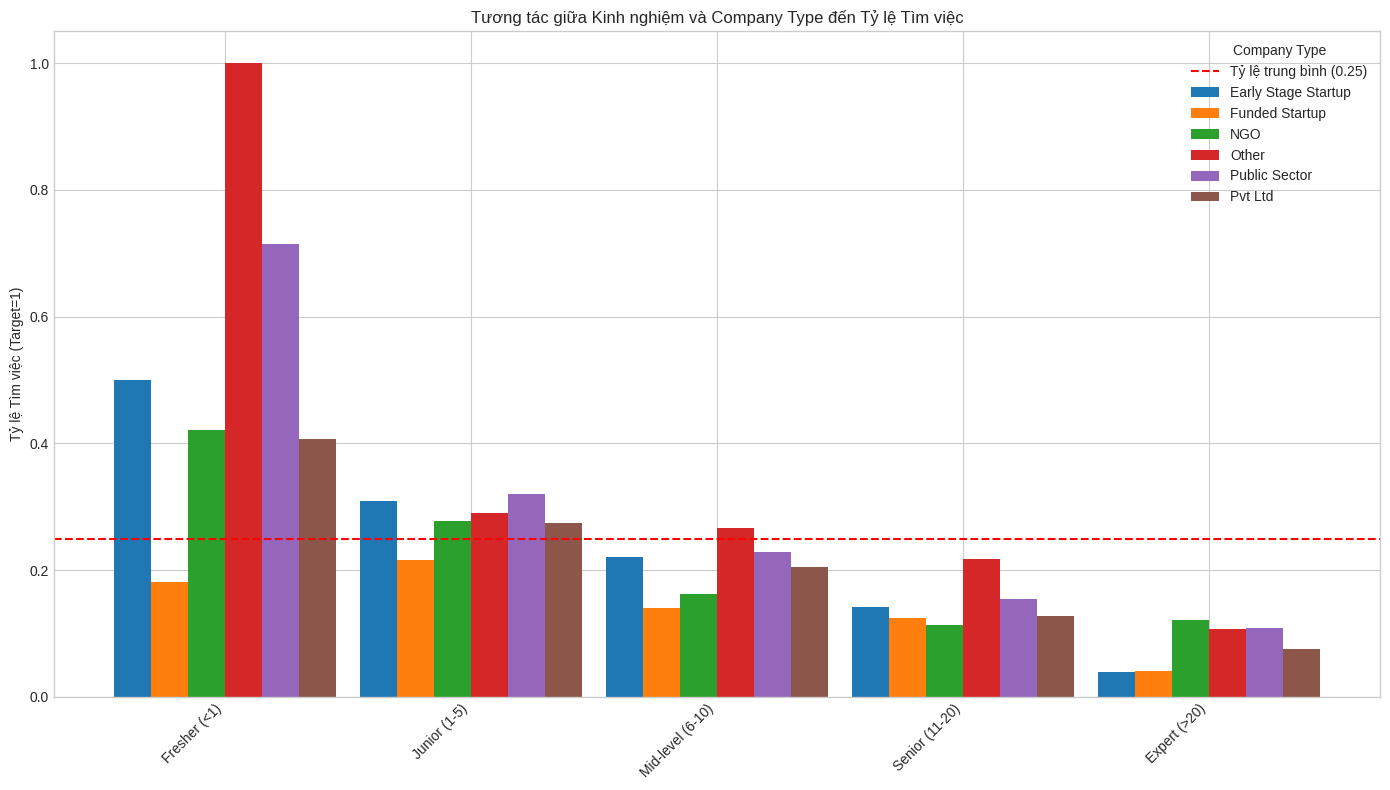

In [34]:
# Phân tích và trực quan hóa sự tương tác
interaction_data = dp.analyze_experience_interaction(data, hue_column='company_type')
viz.plot_experience_interaction(interaction_data)

**Nhận xét:**
* Biểu đồ cho thấy xu hướng tìm việc giảm dần khi kinh nghiệm tăng, điều này đúng với mọi loại hình công ty.
* Tuy nhiên, tốc độ giảm và mức độ chênh lệch là khác nhau. Ở nhóm **Fresher** và **Junior**, tỷ lệ tìm việc ở **'Early Stage Startup'** và **'Startup'** cao hơn đáng kể so với các loại hình khác.
* Ngược lại, ở nhóm **Senior** và **Expert**, tỷ lệ tìm việc không chỉ thấp mà còn khá đồng đều giữa các loại công ty. Điều này cho thấy khi đã có nhiều kinh nghiệm, loại hình công ty ít ảnh hưởng đến quyết định tìm việc hơn.
* **Kết luận:** Sự kết hợp giữa **kinh nghiệm ít** và làm việc tại **startup** tạo ra một nhóm có rủi ro "nhảy việc" cao nhất. Đây là một insight quan trọng mà phân tích đơn biến không thể hiện rõ.

Cả hai biến `company_size` và `company_type` đều cho thấy mối liên hệ mạnh với `target` khi phân tích đơn lẻ. Việc kết hợp chúng sẽ giúp trả lời câu hỏi:

**Câu hỏi:** Liệu xu hướng tìm việc ở các startup có khác nhau giữa startup giai đoạn đầu và startup đã có vốn không? Mối quan hệ giữa quy mô và tỷ lệ tìm việc có đồng nhất ở mọi loại hình công ty không?

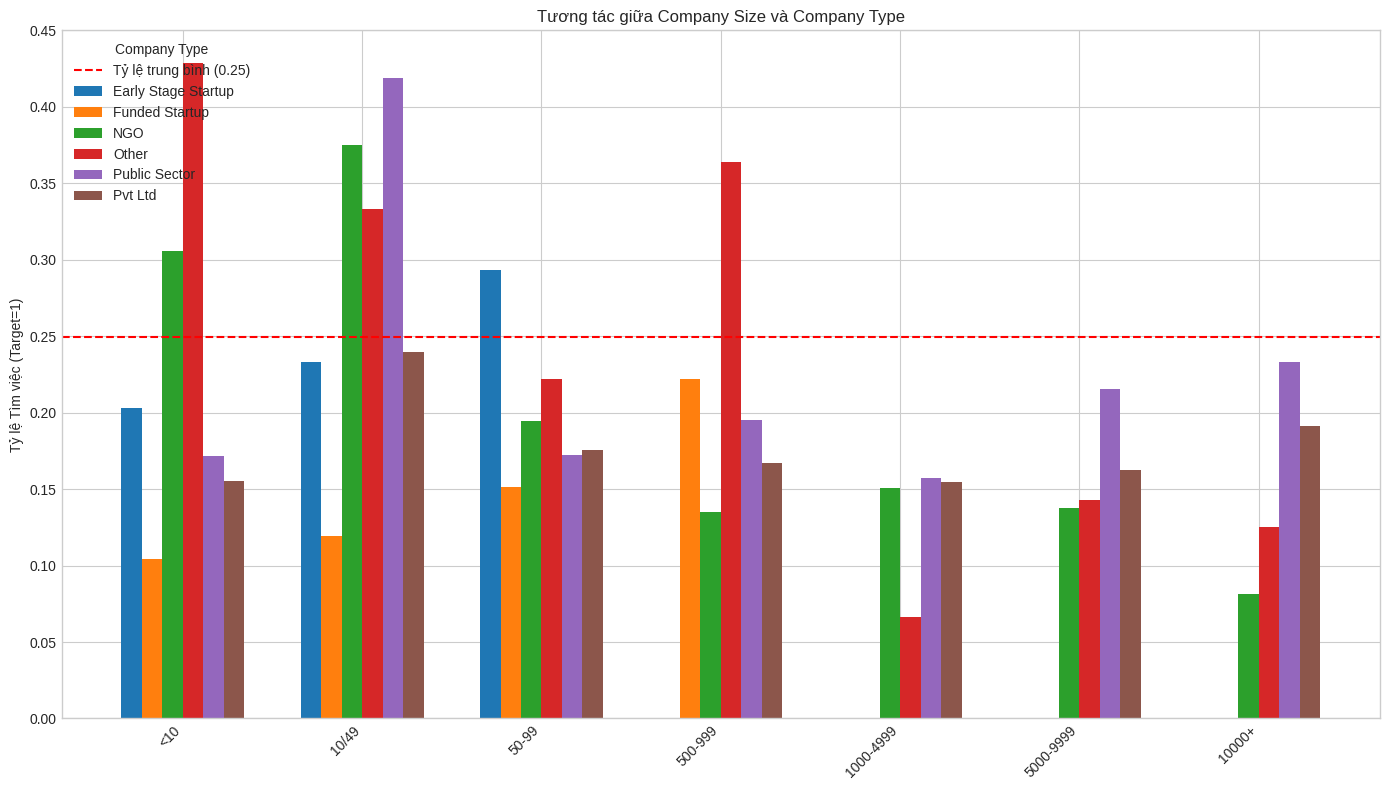

In [35]:
# Phân tích và trực quan hóa sự tương tác
# Để dễ nhìn, ta sắp xếp các cột theo một thứ tự logic
size_order = ['<10', '10/49', '50-99', '100-499', '500-999', '1000-4999', '5000-9999', '10000+']
bivariate_data_1 = dp.analyze_bivariate_categorical(data, x_col='company_size', hue_col='company_type', x_order=size_order)
viz.plot_bivariate_categorical(bivariate_data_1)

Đây là hai yếu tố dự báo mạnh nhất liên quan đến lịch sử làm việc của ứng viên.

**Câu hỏi:** Liệu những người có ít kinh nghiệm và chưa bao giờ chuyển việc (`never`) có phải là nhóm có khả năng tìm việc cao nhất không? Tỷ lệ này thay đổi như thế nào khi kinh nghiệm tăng lên?

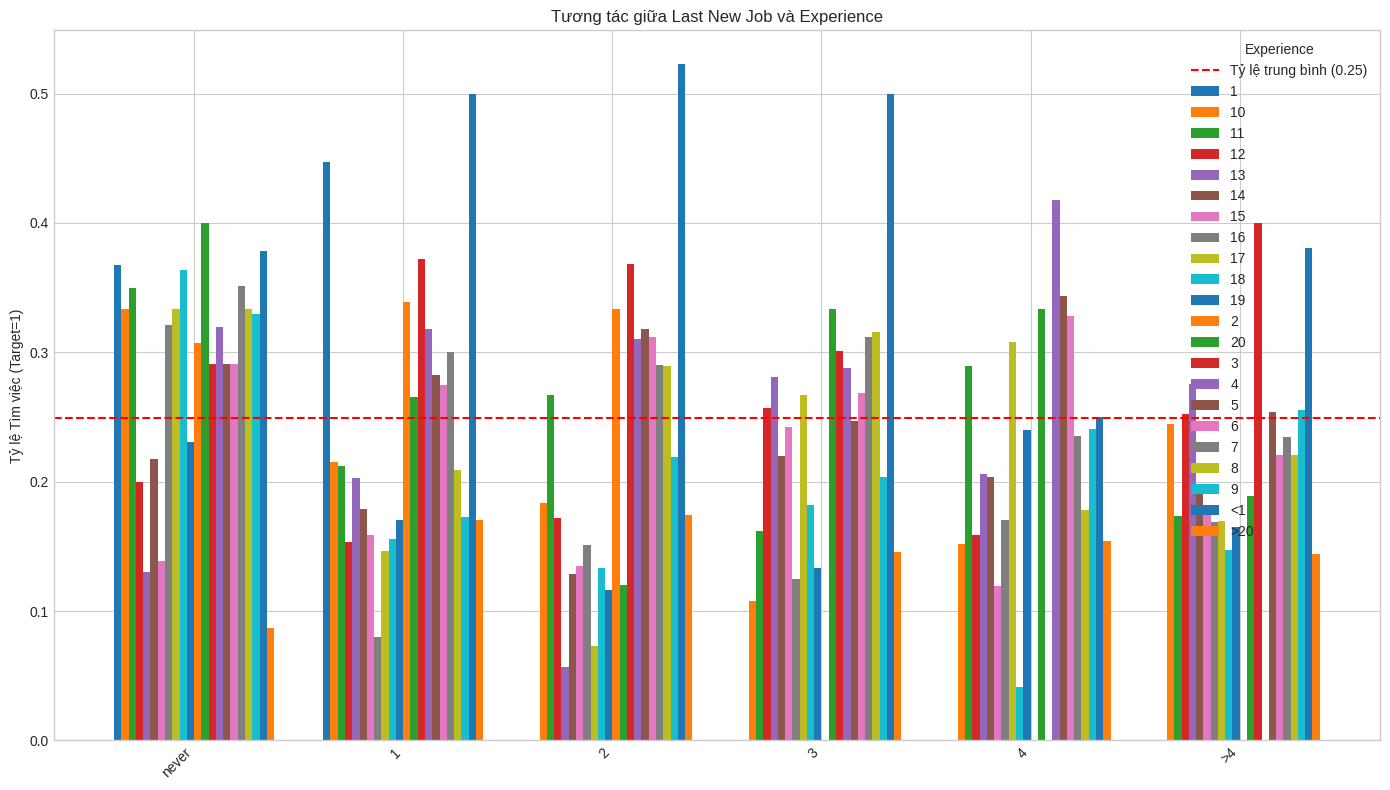

In [36]:
# Sử dụng lại hàm phân tích tương tác kinh nghiệm
# `last_new_job` có tính thứ tự, ta sẽ sắp xếp để biểu đồ dễ đọc hơn
job_order = ['never', '1', '2', '3', '4', '>4']
bivariate_data_2 = dp.analyze_bivariate_categorical(data, x_col='last_new_job', hue_col='experience', x_order=job_order)
viz.plot_bivariate_categorical(bivariate_data_2)

Phân tích này giúp làm rõ liệu việc có kinh nghiệm liên quan hay không ảnh hưởng khác nhau đến các nhóm có trình độ học vấn khác nhau.

**Câu hỏi:** Ở cùng một trình độ học vấn (ví dụ: Graduate), việc không có kinh nghiệm liên quan (`No relevent experience`) có làm tăng đáng kể tỷ lệ tìm việc không?

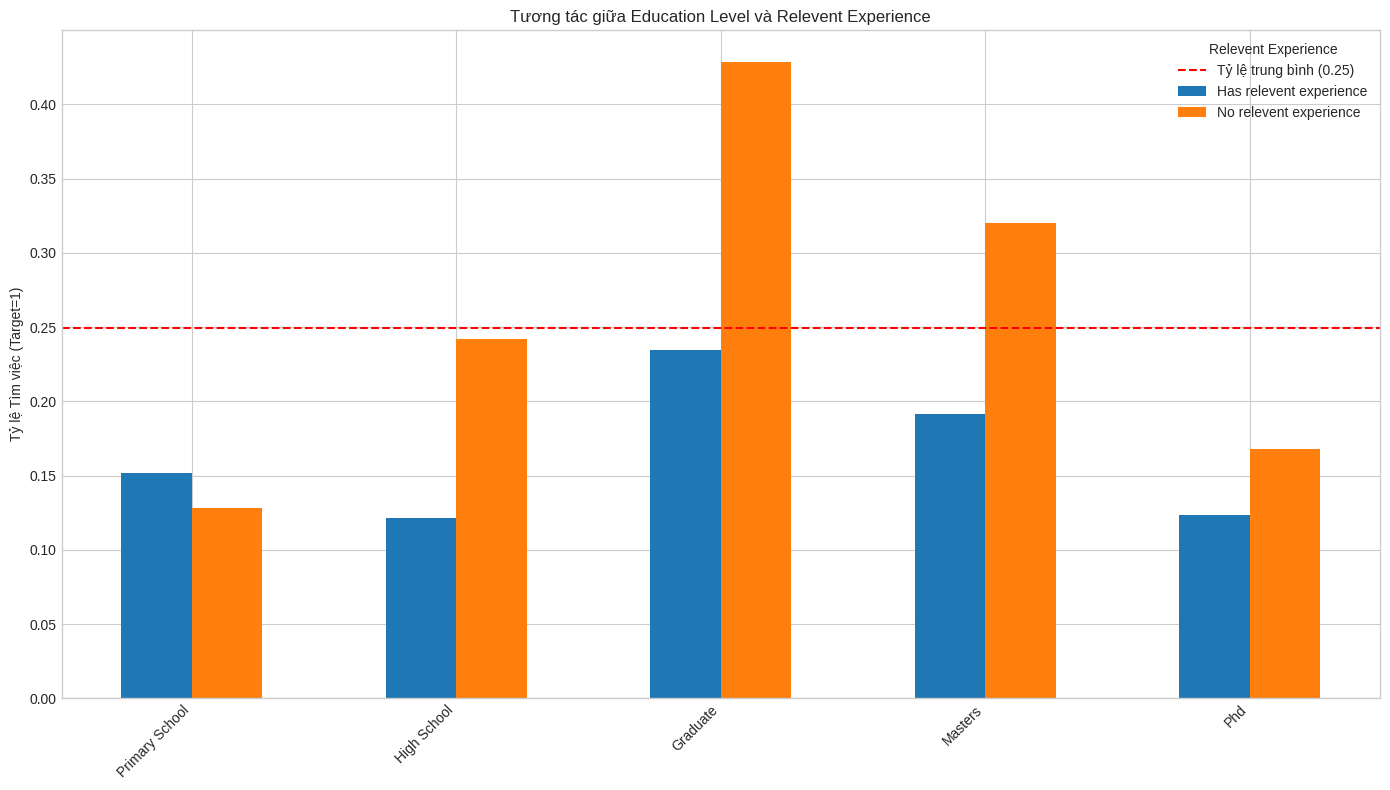

In [37]:
# Phân tích và trực quan hóa sự tương tác
edu_order = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
bivariate_data_3 = dp.analyze_bivariate_categorical(data, x_col='education_level', hue_col='relevent_experience', x_order=edu_order)
viz.plot_bivariate_categorical(bivariate_data_3)

Phân tích này giúp hiểu rõ hơn về hồ sơ của các nhóm "đang đi học".

**Câu hỏi:** Những người đang học "Full time course" chủ yếu có trình độ học vấn là gì? Liệu có phải họ là những người đã tốt nghiệp (`Graduate`) và bây giờ học thêm một khóa khác?

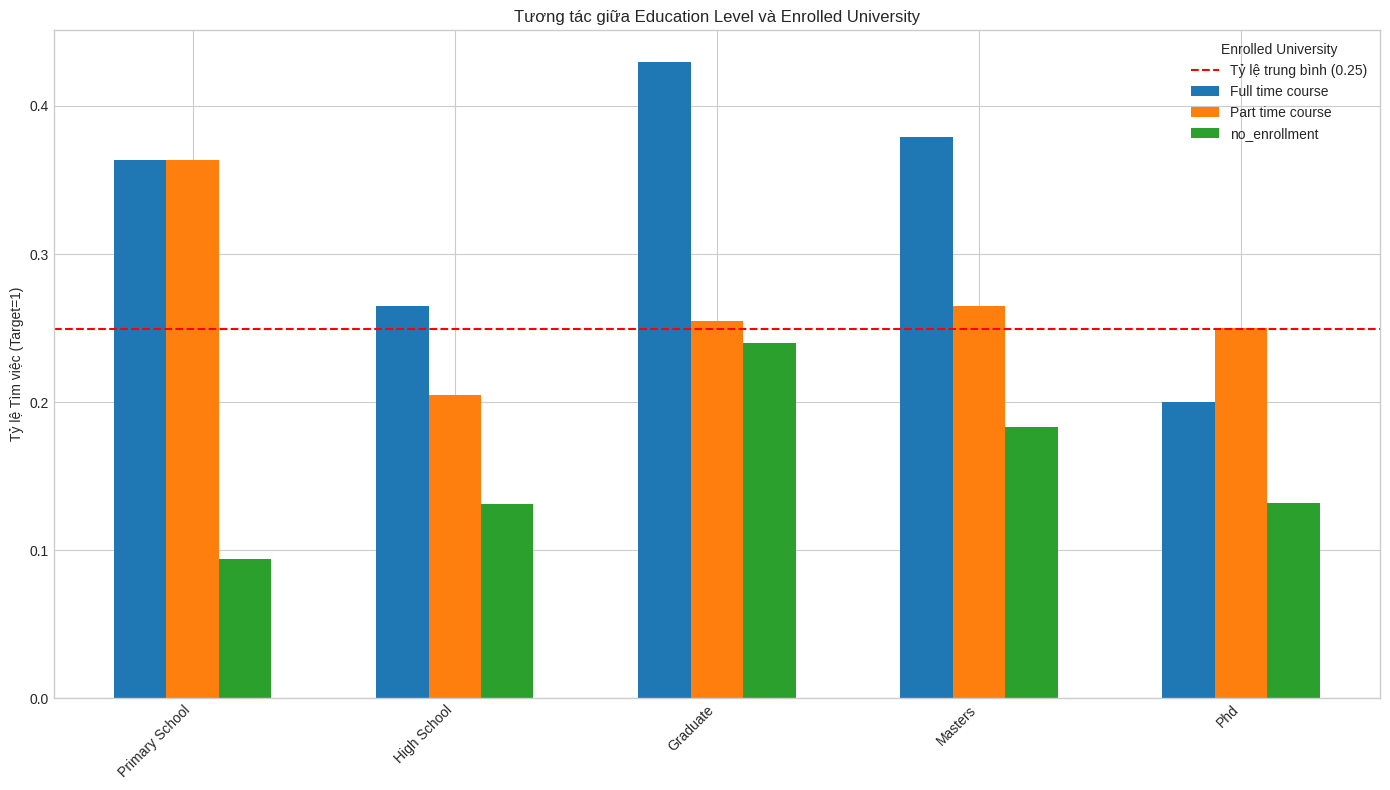

In [38]:
# Phân tích và trực quan hóa sự tương tác
edu_order = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
bivariate_data_4 = dp.analyze_bivariate_categorical(data, x_col='education_level', hue_col='enrolled_university', x_order=edu_order)
viz.plot_bivariate_categorical(bivariate_data_4)

Phân tích đơn biến cho thấy `training_hours` dường như không có ảnh hưởng rõ rệt. Liệu điều này có thay đổi khi ta xét đến yếu tố kinh nghiệm?

**Câu hỏi:** Liệu những người có ít kinh nghiệm có xu hướng học nhiều giờ hơn không? Phân phối số giờ học có khác nhau giữa nhóm tìm việc và không tìm việc ở mỗi mức kinh nghiệm không?

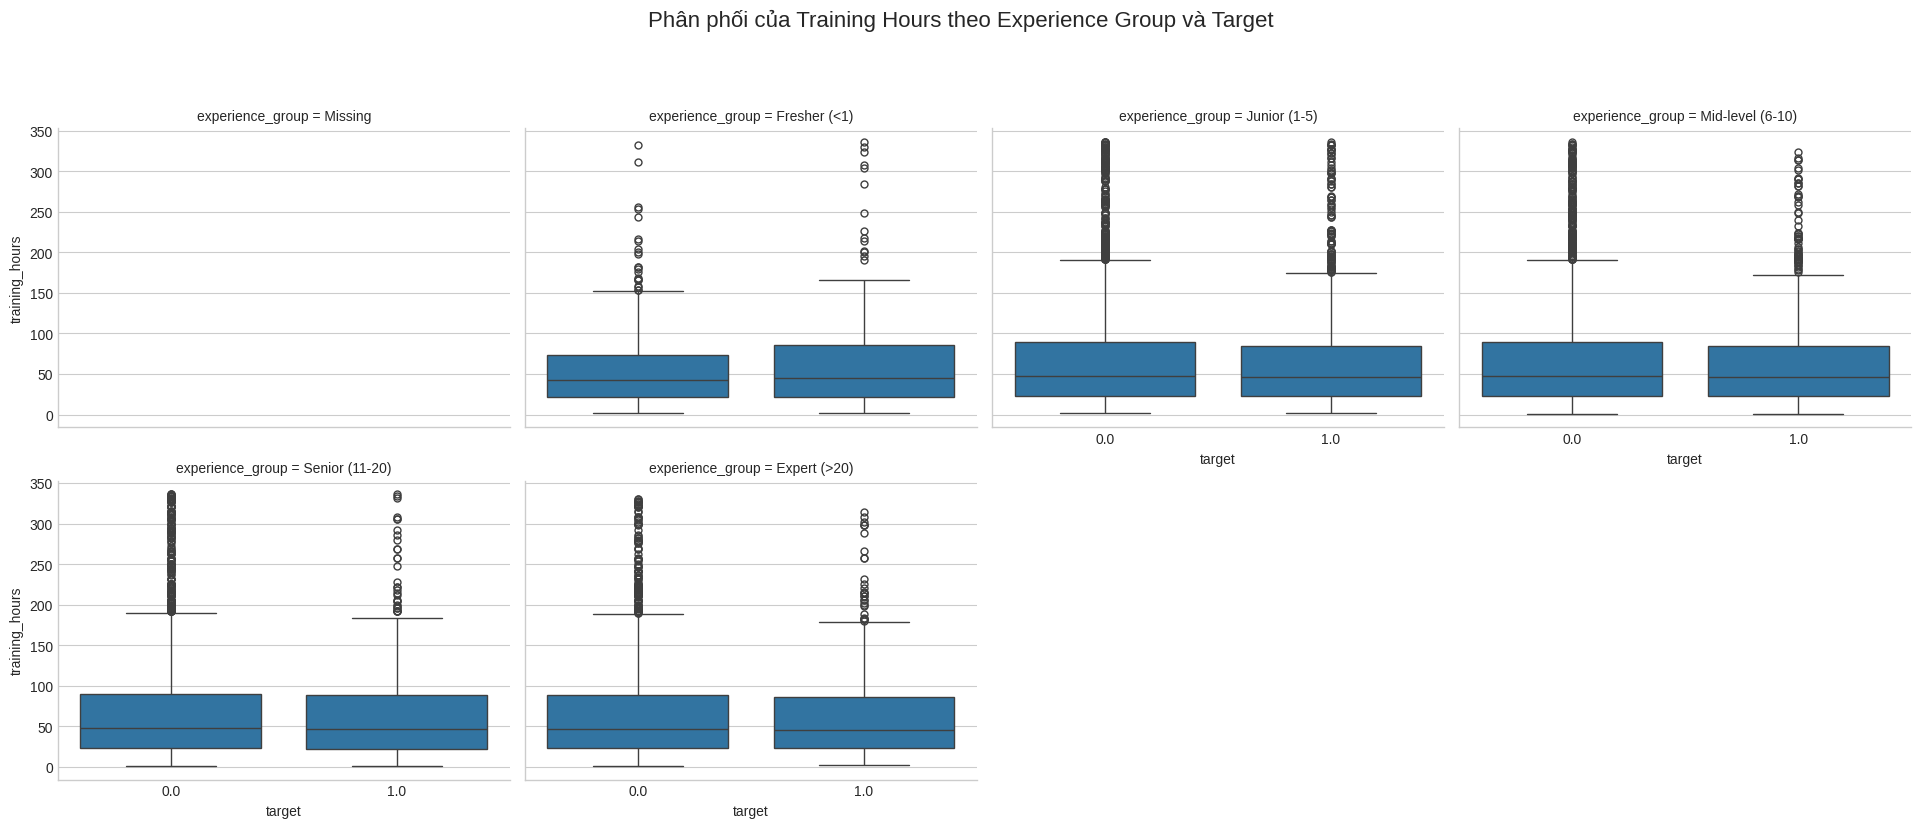

In [39]:
# Phân tích và trực quan hóa sự tương tác
# Đây là trường hợp biến số và biến phân loại, ta dùng biểu đồ box plot
viz.plot_numerical_categorical_interaction(data, num_col='training_hours', cat_col='experience')

---

/home/trungminh/HK1/KHDL/TH/HW02/HR Analytics/src/visualization.py:578: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(train_data["city_development_index"], ax=axes[3], color="gray", shade=True, label="Train")
/home/trungminh/HK1/KHDL/TH/HW02/HR Analytics/src/visualization.py:579: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(test_data["city_development_index"], ax=axes[3], color="#0e4f66", shade=True, label="Test")
/home/trungminh/HK1/KHDL/TH/HW02/HR Analytics/src/visualization.py:605: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxenplot(x=x_vals, y=y_vals, ax=axes[5], palette=["gray", "#0e4f66"])
/

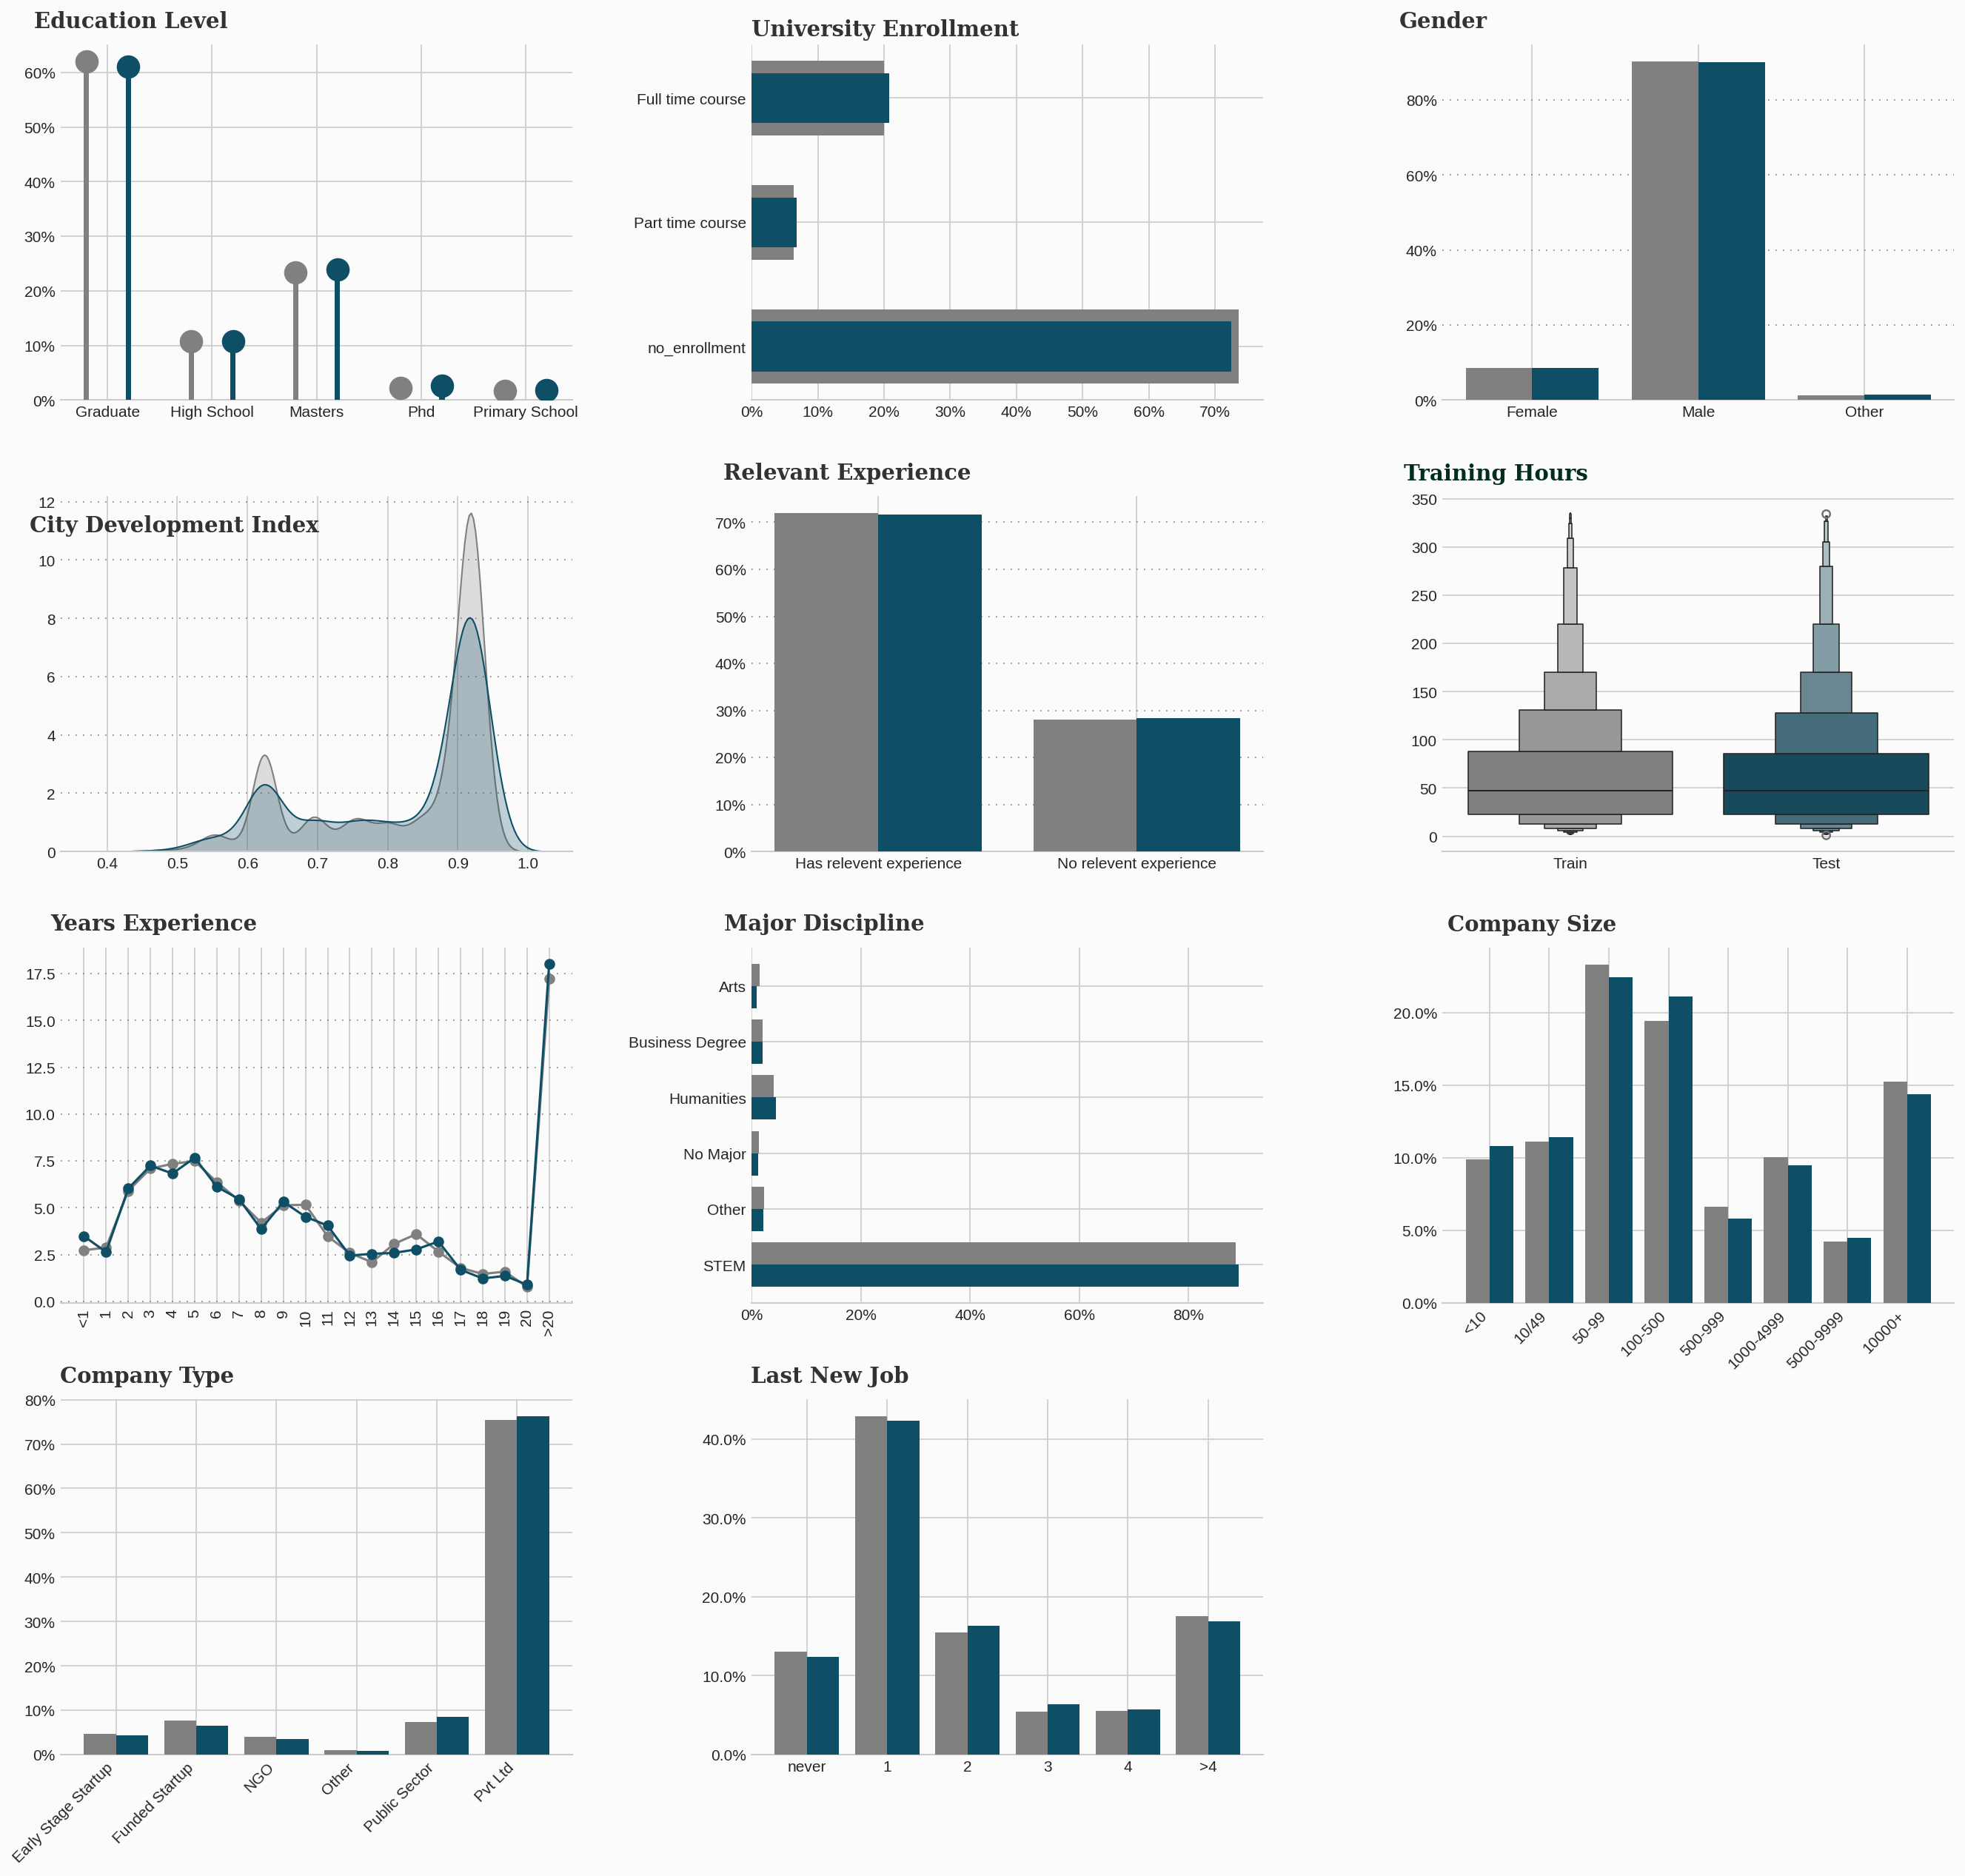

In [40]:
train_data = '../data/raw/aug_train.csv'
test_data = '../data/raw/aug_test.csv'

viz.plot_train_test_comparison(train_data, test_data)

# 5. Quan Sát Ban Đầu & Insights

### 5.1. Tóm tắt các insight chính (Key Observations)

1.  **Hồ sơ ứng viên là yếu tố quyết định:** Các đặc trưng về kinh nghiệm (`experience`, `last_new_job`) và học vấn (`education_level`, `enrolled_university`) là những yếu tố dự báo mạnh mẽ nhất. Chân dung của một ứng viên có khả năng tìm việc cao là:
    *   Ít kinh nghiệm (đặc biệt dưới 5 năm).
    *   Đang là sinh viên học toàn thời gian (`Full time course`).
    *   Mới chỉ tốt nghiệp đại học (`Graduate`).

2.  **Bối cảnh công ty hiện tại rất quan trọng:** Việc thiếu thông tin về công ty (`company_size`, `company_type`) là tín hiệu dự báo mạnh nhất cho thấy ứng viên đang tìm việc. Ngoài ra, nhân viên từ các công ty nhỏ hoặc startup cũng có xu hướng "nhảy việc" cao hơn.

3.  **Yếu tố địa lý có ảnh hưởng:** Ứng viên từ các thành phố có chỉ số phát triển thấp (`city_development_index`) có xu hướng tìm việc cao hơn một cách rõ rệt.

4.  **`training_hours` có ít giá trị dự báo (khi đứng riêng):** Số giờ đào tạo dường như không có mối liên hệ rõ ràng với việc ứng viên có tìm việc hay không.

5.  **Dữ liệu thiếu không phải là ngẫu nhiên (Not Missing At Random - NMAR):** Việc một ứng viên không cung cấp thông tin (đặc biệt là về công ty và giới tính) lại là một dấu hiệu mạnh cho thấy họ đang tìm việc. Đây là một đặc trưng ẩn quan trọng.

### 5.2. Các vấn đề về chất lượng dữ liệu

1.  **Dữ liệu thiếu có chủ đích:** Tỷ lệ thiếu rất cao ở các cột `company_type` (32%), `company_size` (31%), `gender` (24%). Việc thiếu này mang tính dự báo, không phải lỗi ngẫu nhiên.
2.  **Dữ liệu trùng lặp:** Có 49 bản ghi bị trùng lặp (không tính `enrollee_id`) cần được loại bỏ.
3.  **Mất cân bằng lớp (Imbalanced Target):** Biến mục tiêu bị mất cân bằng nghiêm trọng (tỷ lệ 75:25), có thể làm mô hình thiên vị về phía lớp đa số (`target=0`).
4.  **Kiểu dữ liệu chưa phù hợp:** Các biến có thứ tự (`experience`, `education_level`) và biến số (`target`) đang được lưu dưới dạng chuỗi hoặc float, cần được chuyển đổi sang đúng định dạng (ordinal, integer).
5.  **Độ đa dạng (Cardinality) cao:** Cột `city` có 123 giá trị duy nhất, không phù hợp cho one-hot encoding.

### 5.3. Các bước tiền xử lý cần thiết

1.  **Loại bỏ cột không cần thiết:** Bỏ cột `enrollee_id` (chỉ là ID) và `city` (thông tin dư thừa với `city_development_index`).
2.  **Xử lý dữ liệu trùng lặp:** Xóa 49 dòng bị trùng.
3.  **Xử lý dữ liệu thiếu:**
    *   Với các cột có tỷ lệ thiếu cao và mang tính dự báo (`company_size`, `company_type`, `gender`, ...), tạo một hạng mục mới là `"Missing"` hoặc `is_missing` để giữ lại thông tin.
    *   Với các cột có tỷ lệ thiếu thấp (`experience`, `education_level`, ...), có thể điền bằng `mode`.
4.  **Mã hóa biến phân loại (Encoding):**
    *   **Ordinal Encoding:** Áp dụng cho các biến có thứ tự như `experience`, `education_level`, `company_size`, `last_new_job`.
    *   **One-Hot Encoding:** Áp dụng cho các biến không có thứ tự và có ít giá trị duy nhất như `relevent_experience`.
5.  **Chuẩn hóa biến số (Scaling):** Áp dụng `StandardScaler` hoặc `MinMaxScaler` cho `city_development_index` và `training_hours` để đưa chúng về cùng một thang đo.
6.  **Xử lý mất cân bằng:** Sử dụng các kỹ thuật như SMOTE (oversampling), RandomUnderSampler (undersampling), hoặc `class_weight` trong mô hình.

### 5.4. Các câu hỏi/giả thuyết thú vị

*   **Hồ sơ "bí ẩn":** Nhóm ứng viên không điền thông tin công ty và giới tính là ai? Họ có phải là sinh viên mới ra trường, người làm tự do, hay những người có chủ đích che giấu thông tin vì đang muốn rời công ty hiện tại?
*   **"Bẫy" thành phố nhỏ:** Tại sao ứng viên ở các thành phố kém phát triển lại có xu hướng tìm việc cao? Liệu có phải vì thiếu cơ hội tại địa phương hay họ có tham vọng lớn hơn?
*   **Giá trị tiềm ẩn của `training_hours`:** Biến `training_hours` có trở nên hữu ích khi kết hợp với các biến khác không? Ví dụ, một người "không có kinh nghiệm liên quan" nhưng lại hoàn thành rất nhiều giờ đào tạo có phải là một ứng viên tiềm năng và quyết tâm cao không?

### 5.5. Cảnh báo (Red Flags)

*   **Rủi ro từ việc xử lý sai dữ liệu thiếu:** Vấn đề lớn nhất là dữ liệu thiếu không ngẫu nhiên. Nếu chỉ đơn giản xóa các dòng này hoặc điền bằng `mean`/`mode` một cách máy móc, chúng ta sẽ **đánh mất thông tin dự báo quan trọng nhất** của tập dữ liệu.
*   **Tính tổng quát của mô hình:** Mô hình được xây dựng trên dữ liệu của những người đã đăng ký khóa học, vì vậy kết luận rút ra có thể không hoàn toàn đúng khi áp dụng cho toàn bộ thị trường lao động.